In [3]:
import os
import pickle
import numpy as np
import pandas as pd
import spacy

from keras.preprocessing.text import Tokenizer, text_to_word_sequence

from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
%matplotlib inline

from collections import defaultdict

spacy.prefer_gpu()
nlp = spacy.load("en_core_web_sm")
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

## Note to examiners 1
Importing and exporting of dataframes was done to save time from re-running the code. At certain stages of this dissertation, the dataframes were saved as pickle files and loaded at different stages of preprocessing.

The code is written in a way that it can be run from start to finish without having to import the dataframes. Regardless, the most up-to-date preprocessed dataframes, v4, is included in the submission folder. The code blocks below are commented out to prevent accidental re-importing of dataframes, but are left in for transparency and as an example of how the dataframes were imported.

For verification purposes, compare the dataframes generated from running the entire preprocessing code with the "v4" processed dataframes included. The dataframes should be identical.

Throughout this notebook, there are 2 more notes to the examiners. Search for them using "Note to examiners" for easy navigation.


In [15]:
# # import kmeans meta data
# train_data_v2 = pd.read_pickle('train_data_kmeans_meta.p')
# val_data_v2 = pd.read_pickle('val_data_kmeans_meta.p')
# test_data_v2 = pd.read_pickle('test_data_kmeans_meta.p')

In [16]:
# train_data_v2

index          id        label  \
0          0   2635.json        false   
1          1  10540.json    half-true   
2          2    324.json  mostly-true   
3          3   1123.json        false   
4          4   9028.json    half-true   
...      ...         ...          ...   
10235  10235   5473.json  mostly-true   
10236  10236   3408.json  mostly-true   
10237  10237   3959.json    half-true   
10238  10238   2253.json        false   
10239  10239   1155.json   pants-fire   

                                               statement  \
0      Says the Annies List political group supports ...   
1      When did the decline of coal start? It started...   
2      Hillary Clinton agrees with John McCain "by vo...   
3      Health care reform legislation is likely to ma...   
4      The economic turnaround started at the end of ...   
...                                                  ...   
10235  There are a larger number of shark attacks in ...   
10236  Democrats have now become the party of the [At...   
10237  Says an alternative to Social Security that op...   
10238  On lifting the U.S. Cuban embargo and allowing...   
10239  The Department of Veterans Affairs has a manua...   

                                  subject         speaker  \
0                                abortion    dwayne-bohac   
1      energy,history,job-accomplishments  scott-surovell   
2                          foreign-policy    barack-obama   
3                             health-care    blog-posting   
4                            economy,jobs   charlie-crist   
...                                   ...             ...   
10235                   animals,elections    aclu-florida   
10236                           elections     alan-powell   
10237          retirement,social-security     herman-cain   
10238              florida,foreign-policy     jeff-greene   
10239                health-care,veterans  michael-steele   

                                           job-title       party  \
0                               State representative  republican   
1                                     State delegate    democrat   
2                                          President    democrat   
3                                            unknown        none   
4                                            unknown    democrat   
...                                              ...         ...   
10235                                        unknown        none   
10236                                        unknown  republican   
10237                                        unknown  republican   
10238                                        unknown    democrat   
10239  chairman of the Republican National Committee  republican   

       barely-true-counts  false-counts  ...  \
0                     0.0           1.0  ...   
1                     0.0           0.0  ...   
2                    70.0          71.0  ...   
3                     7.0          19.0  ...   
4                    15.0           9.0  ...   
...                   ...           ...  ...   
10235                 0.0           1.0  ...   
10236                 0.0           0.0  ...   
10237                 4.0          11.0  ...   
10238                 3.0           1.0  ...   
10239                 0.0           1.0  ...   

                                                 context  output  \
0                                               a mailer      -2   
1                                        a floor speech.       1   
2                                                 Denver       2   
3                                         a news release      -2   
4                                    an interview on CNN       1   
...                                                  ...     ...   
10235                  interview on "The Colbert Report"       2   
10236                                       an interview       2   
10237                   a Republican presidential deba

In [26]:
# train_data = train_data_v2
# val_data = val_data_v2
# test_data = test_data_v2

In [27]:
# train_data.head()

index          id        label  \
0      0   2635.json        false   
1      1  10540.json    half-true   
2      2    324.json  mostly-true   
3      3   1123.json        false   
4      4   9028.json    half-true   

                                           statement  \
0  Says the Annies List political group supports ...   
1  When did the decline of coal start? It started...   
2  Hillary Clinton agrees with John McCain "by vo...   
3  Health care reform legislation is likely to ma...   
4  The economic turnaround started at the end of ...   

                              subject         speaker             job-title  \
0                            abortion    dwayne-bohac  State representative   
1  energy,history,job-accomplishments  scott-surovell        State delegate   
2                      foreign-policy    barack-obama             President   
3                         health-care    blog-posting               unknown   
4                        economy,jobs   charlie-crist               unknown   

        party  barely-true-counts  false-counts  ...              context  \
0  republican                 0.0           1.0  ...             a mailer   
1    democrat                 0.0           0.0  ...      a floor speech.   
2    democrat                70.0          71.0  ...               Denver   
3        none                 7.0          19.0  ...       a news release   
4    democrat                15.0           9.0  ...  an interview on CNN   

   output               preprocessed-subject preprocessed-context  \
0      -2                           abortion               mailer   
1       1  energy history job accomplishment         floor speech   
2       2                     foreign policy               Denver   
3      -2                        health care         news release   
4       1                        economy job        interview CNN   

   preprocessed-context-clustered preprocessed-job-title preprocessed-party  \
0                               6   state representative         republican   
1                               8         state delegate           democrat   
2                               6              president           democrat   
3                               4                unknown                      
4                               7                unknown           democrat   

   preprocessed-party-clustered preprocessed-job-title-clustered  \
0                             1                                5   
1                             0                                2   
2                             0                                1   
3                             3                                0   
4                             0                                0   

  preprocessed-subject-clustered  
0                              0  
1                              3  
2                              0  
3                              4  
4                              3  

[5 rows x 23 columns]

In [5]:
# importing current state of v4 as of 30 April for verification
# train_data = pd.read_pickle('processed_train_data_v4.p')
# train_data.head()

index          id        label  \
0      0   2635.json        false   
1      1  10540.json    half-true   
2      2    324.json  mostly-true   
3      3   1123.json        false   
4      4   9028.json    half-true   

                                           statement  \
0  Says the Annies List political group supports ...   
1  When did the decline of coal start? It started...   
2  Hillary Clinton agrees with John McCain "by vo...   
3  Health care reform legislation is likely to ma...   
4  The economic turnaround started at the end of ...   

                              subject         speaker             job-title  \
0                            abortion    dwayne-bohac  State representative   
1  energy,history,job-accomplishments  scott-surovell        State delegate   
2                      foreign-policy    barack-obama             President   
3                         health-care    blog-posting               unknown   
4                        economy,jobs   charlie-crist               unknown   

        party  barely-true-counts  false-counts  ...  \
0  republican                 0.0           1.0  ...   
1    democrat                 0.0           0.0  ...   
2    democrat                70.0          71.0  ...   
3        none                 7.0          19.0  ...   
4    democrat                15.0           9.0  ...   

                                         dep-id-fine  \
0         [8, 8, 4, 4, 3, 1, 8, 3, 8, 7, 2, 8, 8, 8]   
1  [8, 8, 8, 1, 8, 7, 8, 8, 1, 8, 8, 3, 1, 8, 8, ...   
2  [7, 1, 8, 8, 7, 8, 8, 8, 8, 8, 8, 7, 8, 8, 2, ...   
3            [7, 7, 7, 1, 8, 8, 8, 8, 3, 7, 7, 2, 8]   
4                  [8, 3, 1, 8, 8, 8, 8, 8, 8, 8, 8]   

                                       dep-id-custom  \
0      [7, 5, 11, 11, 8, 6, 11, 8, 1, 4, 9, 2, 3, 1]   
1  [11, 7, 5, 6, 2, 4, 3, 1, 6, 7, 11, 8, 6, 11, ...   
2  [4, 6, 7, 2, 4, 3, 1, 2, 11, 10, 11, 4, 11, 5,...   
3         [4, 4, 4, 6, 7, 11, 10, 11, 8, 4, 4, 9, 1]   
4                 [5, 8, 6, 7, 2, 5, 3, 2, 11, 3, 1]   

                                 statement-customswr  \
0  say annies list political group support third ...   
1  when do decline coal start start when natural ...   
2  hillary clinton agree john mccain vote give ge...   
3  health care reform legislation be likely manda...   
4                 economic turnaround start end term   

                                  statement-spacyswr  job-id-jaccard  \
0  say annies list political group support trimes...               2   
1  decline coal start start natural gas take star...               6   
2  hillary clinton agree john mccain vote george ...               2   
3  health care reform legislation likely mandate ...               0   
4                 economic turnaround start end term               0   

  party-id-jaccard context-id-jaccard  subject-id-jaccard  \
0                0                 13                   2   
1                1                  0                   5   
2                1                  3                   5   
3                2                  0                   0   
4                1                  3                   6   

                                      word-id-custom  \
0  [3, 5440, 717, 493, 396, 54, 274, 4039, 155, 1...   
1  [37, 9, 804, 861, 308, 308, 37, 981, 254, 39, ...   
2  [104, 69, 734, 160, 201, 18, 89, 262, 137, 258...   
3  [19, 22, 209, 252, 1, 592, 406, 361, 439, 176,...   
4                         [282, 3331, 308, 247, 248]   

                                       word-id-spacy  
0       [1, 5315, 633, 423, 332, 37, 3919, 120, 936]  
1  [720, 773, 249, 249, 891, 204, 46, 249, 527, 1...  
2  [74, 49, 649, 125, 157, 12, 212, 103, 208, 274...  
3  [13, 16, 165, 202, 514, 342, 301, 372, 140, 2747]  
4                         [224, 3208, 249, 198, 199]  

[5 rows x 36 columns]

# Preprocessing

## DataFrame Cleaning

In [12]:
### April 15th Following Nida Aslam et al. (2021) paper

def clean_dataframe(data, label_map):
    """
    Clean the dataframe by removing rows with missing values in 'statement' column and replacing missing values in other columns with empty strings.
    :param data: {pd.DataFrame} input dataframe
    :param label_map: {dict} mapping labels to numerical values
    :return: {pd.DataFrame} cleaned dataframe
    """
    # maps labels to numerical values to 'output' column
    data['output'] = data['label'].apply(lambda x: label_map[x])

    # replace missing values with empty strings
    data['subject'] = data['subject'].fillna('unknown')
    data['speaker'] = data['speaker'].fillna('unknown')
    data['job-title'] = data['job-title'].fillna('unknown')
    # data['state_info'] = data['state_info'].fillna('')
    data['party'] = data['party'].fillna('unknown')
    data['context'] = data['context'].fillna('unknown')

    # drop rows where there are missing values in 'statement'
    data.drop(index=data[data.statement==' '].index, inplace=True)
    data.drop(index=data[data.statement=='  '].index, inplace=True)
    data.drop(index=data[data.statement=='\n'].index, inplace=True)

    # drop columns
    # data.drop(columns=['context'], inplace=True)
    # data.drop(columns=['id'], inplace=True)
    data.drop(columns=['state'], inplace=True)
    # data.drop(columns=['party'], inplace=True)

    # reset index
    data = data.reset_index()

    return data

In [10]:
# column titles and label maps
columns = ['id','label','statement','subject','speaker','job-title','state','party','barely-true-counts','false-counts','half-true-counts','mostly-true-counts','pants-on-fire-counts','context']
label_map = {'pants-fire':0, 'false':1, 'barely-true':2, 'half-true':3, 'mostly-true':4, 'true':5}

In [5]:
# READ dataset files as pandas dataframes
train_data = pd.read_csv('train.tsv', sep='\t', header=None, names=columns)
val_data = pd.read_csv('valid.tsv', sep='\t', header=None, names=columns)
test_data = pd.read_csv('test.tsv', sep='\t', header=None, names=columns)

In [6]:
train_data = clean_dataframe(train_data, label_map)
val_data = clean_dataframe(val_data, label_map)
test_data = clean_dataframe(test_data, label_map)

In [168]:
train_data

index          id        label  \
0          0   2635.json        false   
1          1  10540.json    half-true   
2          2    324.json  mostly-true   
3          3   1123.json        false   
4          4   9028.json    half-true   
...      ...         ...          ...   
10235  10235   5473.json  mostly-true   
10236  10236   3408.json  mostly-true   
10237  10237   3959.json    half-true   
10238  10238   2253.json        false   
10239  10239   1155.json   pants-fire   

                                               statement  \
0      Says the Annies List political group supports ...   
1      When did the decline of coal start? It started...   
2      Hillary Clinton agrees with John McCain "by vo...   
3      Health care reform legislation is likely to ma...   
4      The economic turnaround started at the end of ...   
...                                                  ...   
10235  There are a larger number of shark attacks in ...   
10236  Democrats have now become the party of the [At...   
10237  Says an alternative to Social Security that op...   
10238  On lifting the U.S. Cuban embargo and allowing...   
10239  The Department of Veterans Affairs has a manua...   

                                  subject         speaker  \
0                                abortion    dwayne-bohac   
1      energy,history,job-accomplishments  scott-surovell   
2                          foreign-policy    barack-obama   
3                             health-care    blog-posting   
4                            economy,jobs   charlie-crist   
...                                   ...             ...   
10235                   animals,elections    aclu-florida   
10236                           elections     alan-powell   
10237          retirement,social-security     herman-cain   
10238              florida,foreign-policy     jeff-greene   
10239                health-care,veterans  michael-steele   

                                           job-title       party  \
0                               State representative  republican   
1                                     State delegate    democrat   
2                                          President    democrat   
3                                            unknown        none   
4                                            unknown    democrat   
...                                              ...         ...   
10235                                        unknown        none   
10236                                        unknown  republican   
10237                                        unknown  republican   
10238                                        unknown    democrat   
10239  chairman of the Republican National Committee  republican   

       barely-true-counts  false-counts  ...  \
0                     0.0           1.0  ...   
1                     0.0           0.0  ...   
2                    70.0          71.0  ...   
3                     7.0          19.0  ...   
4                    15.0           9.0  ...   
...                   ...           ...  ...   
10235                 0.0           1.0  ...   
10236                 0.0           0.0  ...   
10237                 4.0          11.0  ...   
10238                 3.0           1.0  ...   
10239                 0.0           1.0  ...   

                                                 context  output  \
0                                               a mailer      -2   
1                                        a floor speech.       1   
2                                                 Denver       2   
3                                         a news release      -2   
4                                    an interview on CNN       1   
...                                                  ...     ...   
10235                  interview on "The Colbert Report"       2   
10236                                       an interview       2   
10237                   a Republican presidential deba

In [169]:
train_data['preprocessed-party'].sample(20)

7036     republican
7366     republican
1623     journalist
6631     republican
5329     republican
8295     republican
9107       democrat
3067     republican
5193     republican
2542       democrat
5665     republican
2416       democrat
604      republican
8258     republican
2059               
6683               
9356     republican
2296     republican
3680       democrat
10139    republican
Name: preprocessed-party, dtype: object

In [14]:
print('real news count')
train_data[train_data['output']>0].count()

real news count


index            5752
id               5752
label            5752
statement        5752
subject          5752
speaker          5752
job_title        5752
state_info       5752
party            5752
barely true      5752
false            5752
half-true        5752
mostly-true      5752
pants-on-fire    5752
context          5752
output           5752
dtype: int64

# POS ID

In [33]:
def get_tag_id(statement, tag_dict, tag_type):
    """
    Extracts tags from statement column.

    :param statement: {str} news content to be processed
    :param tag_dict: {dict} dictionary of predefined tags
    :param tag_type: {str} type of tag to extract, either 'pos', 'fine_pos', or 'dep'
    :return: tag_list: {list} processed statement as a list of tags
    """

    if tag_type not in ['pos', 'tag', 'dep']:
        raise ValueError("Invalid tag_type. Choose from 'pos', 'tag', or 'dep'.")

    tag_dict = defaultdict(lambda: tag_dict['OTHER'], tag_dict)
    tag_list = [tag_dict[getattr(token, tag_type + '_')] for token in nlp(statement)]
    return tag_list


In [6]:
# pos_dict from Ana Salwa Shafie et al. (2018)
pos_dict_fine = {
    'JJ': 1,  # Adjective
    'JJR': 2,  # Adjective, comparative
    'JJS': 3,  # Adjective, superlative
    'VB': 4,  # Verb, base form
    'VBD': 5,  # Verb, past tense
    'VBG': 6,  # Verb, gerund or present participle
    'VBN': 7,  # Verb, past participle
    'VBP': 8,  # Verb, non-3rd person singular present
    'VBZ': 9,  # Verb, 3rd person singular present
    'NN': 10,  # Noun, singular or mass
    'NNS': 11,  # Noun, plural
    'NNP': 12,  # Proper noun, singular
    'RB': 13,  # Adverb
    'RBR': 14,  # Adverb, comparative
    'RBS': 15,  # Adverb, superlative
    'OTHER': 16,
}

# # pos dictionary based on spacy default, unmerged unordered
# ## UNUSED DUE TO MINIMAL DIFFERENCE FROM CUSTOM
# pos_dict_default = {
#     'ADJ': 1,
#     'ADP': 2,
#     'ADV': 3,
#     'AUX': 4,
#     'CONJ': 5,
#     'DET': 6,
#     'INTJ': 7,
#     'NOUN': 8,
#     'NUM': 9,
#     'PART': 10,
#     'PRON': 11,
#     'PROPN': 12,
#     'PUNCT': 13,
#     'X': 14,
#     'SCONJ': 15,
#     'SYM': 16,
#     'VERB': 17,
#     'OTHER': 18
# }

# spacy pos dict, with 'OTHER' tag for least important tags (e.g. SYM, X)
pos_dict_spacy = {'NOUN': 1, 'VERB': 2, 'ADJ': 3, 'ADV': 4, 'ADP': 5, 'PRON': 6,
                   'NUM': 7, 'SCONJ': 8, 'PROPN': 9, 'CONJ': 10, 'PUNCT': 11, 'AUX': 12,
                   'PART': 13, 'INTJ': 14, 'OTHER':15}

# reduced feature complexity
pos_dict_fine_merged = {
    'JJ': 1,  # Adjective
    'JJR': 1,  # Adjective, comparative
    'JJS': 1,  # Adjective, superlative
    'VB': 2,  # Verb, base form
    'VBD': 2,  # Verb, past tense
    'VBG': 2,  # Verb, gerund or present participle
    'VBN': 2,  # Verb, past participle
    'VBP': 2,  # Verb, non-3rd person singular present
    'VBZ': 2,  # Verb, 3rd person singular present
    'NN': 3,  # Noun, singular or mass
    'NNS': 3,  # Noun, plural
    'NNP': 3,  # Proper noun, singular
    'RB': 4,  # Adverb
    'RBR': 4,  # Adverb, comparative
    'RBS': 4,  # Adverb, superlative
    'OTHER': 5,
}

# save dictionaries
with open('pos_dicts.p', 'wb') as f:
    pickle.dump((pos_dict_spacy, pos_dict_fine, pos_dict_fine_merged), f)

In [26]:
print(len(pos_dict_fine))

16


In [28]:
train_data['pos-id-fine'] = train_data['statement'].apply(get_tag_id, tag_dict=pos_dict_fine, tag_type='tag')
val_data['pos-id-fine'] = val_data['statement'].apply(get_tag_id, tag_dict=pos_dict_fine, tag_type='tag')
test_data['pos-id-fine'] = test_data['statement'].apply(get_tag_id, tag_dict=pos_dict_fine, tag_type='tag')

train_data.head()

index          id        label  \
0      0   2635.json        false   
1      1  10540.json    half-true   
2      2    324.json  mostly-true   
3      3   1123.json        false   
4      4   9028.json    half-true   

                                           statement  \
0  Says the Annies List political group supports ...   
1  When did the decline of coal start? It started...   
2  Hillary Clinton agrees with John McCain "by vo...   
3  Health care reform legislation is likely to ma...   
4  The economic turnaround started at the end of ...   

                              subject         speaker             job-title  \
0                            abortion    dwayne-bohac  State representative   
1  energy,history,job-accomplishments  scott-surovell        State delegate   
2                      foreign-policy    barack-obama             President   
3                         health-care    blog-posting               unknown   
4                        economy,jobs   charlie-crist               unknown   

        party  barely-true-counts  false-counts  ...  output  \
0  republican                 0.0           1.0  ...      -2   
1    democrat                 0.0           0.0  ...       1   
2    democrat                70.0          71.0  ...       2   
3        none                 7.0          19.0  ...      -2   
4    democrat                15.0           9.0  ...       1   

                preprocessed-subject  preprocessed-context  \
0                           abortion                mailer   
1  energy history job accomplishment          floor speech   
2                     foreign policy                Denver   
3                        health care          news release   
4                        economy job         interview CNN   

  preprocessed-context-clustered  preprocessed-job-title preprocessed-party  \
0                              6    state representative         republican   
1                              8          state delegate           democrat   
2                              6               president           democrat   
3                              4                 unknown                      
4                              7                 unknown           democrat   

  preprocessed-party-clustered  preprocessed-job-title-clustered  \
0                            1                                 5   
1                            0                                 2   
2                            0                                 1   
3                            3                                 0   
4                            0                                 0   

  preprocessed-subject-clustered  \
0                              0   
1                              3   
2                              0   
3                              4   
4                              3   

                                         pos-id-fine  
0  [9, 16, 16, 12, 1, 10, 9, 1, 16, 10, 11, 16, 1...  
1  [16, 5, 16, 10, 16, 10, 10, 16, 16, 5, 16, 1, ...  
2  [12, 12, 9, 16, 12, 12, 16, 16, 6, 16, 4, 12, ...  
3   [10, 10, 10, 10, 9, 1, 16, 4, 1, 10, 10, 11, 16]  
4         [16, 1, 10, 5, 16, 16, 10, 16, 16, 10, 16]  

[5 rows x 24 columns]

In [29]:
train_data['pos-id-fine-merged'] = train_data['statement'].apply(get_tag_id, tag_dict=pos_dict_fine_merged, tag_type='tag')
val_data['pos-id-fine-merged'] = val_data['statement'].apply(get_tag_id, tag_dict=pos_dict_fine_merged, tag_type='tag')
test_data['pos-id-fine-merged'] = test_data['statement'].apply(get_tag_id, tag_dict=pos_dict_fine_merged, tag_type='tag')

train_data.head()

index          id        label  \
0      0   2635.json        false   
1      1  10540.json    half-true   
2      2    324.json  mostly-true   
3      3   1123.json        false   
4      4   9028.json    half-true   

                                           statement  \
0  Says the Annies List political group supports ...   
1  When did the decline of coal start? It started...   
2  Hillary Clinton agrees with John McCain "by vo...   
3  Health care reform legislation is likely to ma...   
4  The economic turnaround started at the end of ...   

                              subject         speaker             job-title  \
0                            abortion    dwayne-bohac  State representative   
1  energy,history,job-accomplishments  scott-surovell        State delegate   
2                      foreign-policy    barack-obama             President   
3                         health-care    blog-posting               unknown   
4                        economy,jobs   charlie-crist               unknown   

        party  barely-true-counts  false-counts  ...  \
0  republican                 0.0           1.0  ...   
1    democrat                 0.0           0.0  ...   
2    democrat                70.0          71.0  ...   
3        none                 7.0          19.0  ...   
4    democrat                15.0           9.0  ...   

                preprocessed-subject  preprocessed-context  \
0                           abortion                mailer   
1  energy history job accomplishment          floor speech   
2                     foreign policy                Denver   
3                        health care          news release   
4                        economy job         interview CNN   

   preprocessed-context-clustered preprocessed-job-title  preprocessed-party  \
0                               6   state representative          republican   
1                               8         state delegate            democrat   
2                               6              president            democrat   
3                               4                unknown                       
4                               7                unknown            democrat   

  preprocessed-party-clustered preprocessed-job-title-clustered  \
0                            1                                5   
1                            0                                2   
2                            0                                1   
3                            3                                0   
4                            0                                0   

   preprocessed-subject-clustered  \
0                               0   
1                               3   
2                               0   
3                               4   
4                               3   

                                         pos-id-fine  \
0  [9, 16, 16, 12, 1, 10, 9, 1, 16, 10, 11, 16, 1...   
1  [16, 5, 16, 10, 16, 10, 10, 16, 16, 5, 16, 1, ...   
2  [12, 12, 9, 16, 12, 12, 16, 16, 6, 16, 4, 12, ...   
3   [10, 10, 10, 10, 9, 1, 16, 4, 1, 10, 10, 11, 16]   
4         [16, 1, 10, 5, 16, 16, 10, 16, 16, 10, 16]   

                                  pos-id-fine-merged  
0         [2, 5, 5, 3, 1, 3, 2, 1, 5, 3, 3, 5, 3, 5]  
1  [5, 2, 5, 3, 5, 3, 3, 5, 5, 2, 5, 1, 3, 2, 5, ...  
2  [3, 3, 2, 5, 3, 3, 5, 5, 2, 5, 2, 3, 3, 5, 3, ...  
3            [3, 3, 3, 3, 2, 1, 5, 2, 1, 3, 3, 3, 5]  
4                  [5, 1, 3, 2, 5, 5, 3, 5, 5, 3, 5]  

[5 rows x 25 columns]

In [30]:
train_data['pos-id-spacy'] = train_data['statement'].apply(get_tag_id, tag_dict=pos_dict_spacy, tag_type='pos')
val_data['pos-id-spacy'] = val_data['statement'].apply(get_tag_id, tag_dict=pos_dict_spacy, tag_type='pos')
test_data['pos-id-spacy'] = test_data['statement'].apply(get_tag_id, tag_dict=pos_dict_spacy, tag_type='pos')

train_data.head()

index          id        label  \
0      0   2635.json        false   
1      1  10540.json    half-true   
2      2    324.json  mostly-true   
3      3   1123.json        false   
4      4   9028.json    half-true   

                                           statement  \
0  Says the Annies List political group supports ...   
1  When did the decline of coal start? It started...   
2  Hillary Clinton agrees with John McCain "by vo...   
3  Health care reform legislation is likely to ma...   
4  The economic turnaround started at the end of ...   

                              subject         speaker             job-title  \
0                            abortion    dwayne-bohac  State representative   
1  energy,history,job-accomplishments  scott-surovell        State delegate   
2                      foreign-policy    barack-obama             President   
3                         health-care    blog-posting               unknown   
4                        economy,jobs   charlie-crist               unknown   

        party  barely-true-counts  false-counts  ...  preprocessed-context  \
0  republican                 0.0           1.0  ...                mailer   
1    democrat                 0.0           0.0  ...          floor speech   
2    democrat                70.0          71.0  ...                Denver   
3        none                 7.0          19.0  ...          news release   
4    democrat                15.0           9.0  ...         interview CNN   

   preprocessed-context-clustered  preprocessed-job-title preprocessed-party  \
0                               6    state representative         republican   
1                               8          state delegate           democrat   
2                               6               president           democrat   
3                               4                 unknown                      
4                               7                 unknown           democrat   

   preprocessed-party-clustered preprocessed-job-title-clustered  \
0                             1                                5   
1                             0                                2   
2                             0                                1   
3                             3                                0   
4                             0                                0   

  preprocessed-subject-clustered  \
0                              0   
1                              3   
2                              0   
3                              4   
4                              3   

                                         pos-id-fine  \
0  [9, 16, 16, 12, 1, 10, 9, 1, 16, 10, 11, 16, 1...   
1  [16, 5, 16, 10, 16, 10, 10, 16, 16, 5, 16, 1, ...   
2  [12, 12, 9, 16, 12, 12, 16, 16, 6, 16, 4, 12, ...   
3   [10, 10, 10, 10, 9, 1, 16, 4, 1, 10, 10, 11, 16]   
4         [16, 1, 10, 5, 16, 16, 10, 16, 16, 10, 16]   

                                  pos-id-fine-merged  \
0         [2, 5, 5, 3, 1, 3, 2, 1, 5, 3, 3, 5, 3, 5]   
1  [5, 2, 5, 3, 5, 3, 3, 5, 5, 2, 5, 1, 3, 2, 5, ...   
2  [3, 3, 2, 5, 3, 3, 5, 5, 2, 5, 2, 3, 3, 5, 3, ...   
3            [3, 3, 3, 3, 2, 1, 5, 2, 1, 3, 3, 3, 5]   
4                  [5, 1, 3, 2, 5, 5, 3, 5, 5, 3, 5]   

                                       pos-id-custom  
0      [2, 15, 9, 9, 3, 1, 2, 3, 11, 1, 1, 5, 1, 11]  
1  [8, 2, 15, 1, 5, 1, 1, 11, 6, 2, 8, 3, 1, 2, 5...  
2  [9, 9, 2, 5, 9, 9, 11, 5, 2, 13, 2, 9, 9, 15, ...  
3         [1, 1, 1, 1, 12, 3, 13, 2, 3, 1, 1, 1, 11]  
4               [15, 3, 1, 2, 5, 15, 1, 5, 6, 1, 11]  

[5 rows x 26 columns]

In [30]:
train_data

index          id        label  \
0          0   2635.json        false   
1          1  10540.json    half-true   
2          2    324.json  mostly-true   
3          3   1123.json        false   
4          4   9028.json    half-true   
...      ...         ...          ...   
10235  10235   5473.json  mostly-true   
10236  10236   3408.json  mostly-true   
10237  10237   3959.json    half-true   
10238  10238   2253.json        false   
10239  10239   1155.json   pants-fire   

                                               statement  \
0      Says the Annies List political group supports ...   
1      When did the decline of coal start? It started...   
2      Hillary Clinton agrees with John McCain "by vo...   
3      Health care reform legislation is likely to ma...   
4      The economic turnaround started at the end of ...   
...                                                  ...   
10235  There are a larger number of shark attacks in ...   
10236  Democrats have now become the party of the [At...   
10237  Says an alternative to Social Security that op...   
10238  On lifting the U.S. Cuban embargo and allowing...   
10239  The Department of Veterans Affairs has a manua...   

                                  subject         speaker  \
0                                abortion    dwayne-bohac   
1      energy,history,job-accomplishments  scott-surovell   
2                          foreign-policy    barack-obama   
3                             health-care    blog-posting   
4                            economy,jobs   charlie-crist   
...                                   ...             ...   
10235                   animals,elections    aclu-florida   
10236                           elections     alan-powell   
10237          retirement,social-security     herman-cain   
10238              florida,foreign-policy     jeff-greene   
10239                health-care,veterans  michael-steele   

                                           job_title state_info       party  \
0                               State representative      Texas  republican   
1                                     State delegate   Virginia    democrat   
2                                          President   Illinois    democrat   
3                                                                      none   
4                                                       Florida    democrat   
...                                              ...        ...         ...   
10235                                                   Florida        none   
10236                                                   Georgia  republican   
10237                                                   Georgia  republican   
10238                                                   Florida    democrat   
10239  chairman of the Republican National Committee   Maryland  republican   

       barely true  ...  output  subject_id  speaker_id  job_id state_id  \
0              0.0  ...      -2           2          25       1        1   
1              0.0  ...       1           5           4       6        7   
2             70.0  ...       2           5           0       2        3   
3              7.0  ...      -2           0          18       0        0   
4             15.0  ...       1           6           2       0        2   
...            ...  ...     ...         ...         ...     ...      ...   
10235          0.0  ...       2           2           8       0        2   
10236          0.0  ...       2           3          25       0        7   
10237          4.0  ...       1           2           2       0        7   
10238          3.0  ...      -2           5          25       0        2   
10239          0.0  ...      -3           0           7       6       20   

       party_id  context_id  \
0             0           2   
1             1           2   
2             1           8   
3             2           0   
4             1           1   
...         

## DEP ID

In [6]:

dep_dict_custom = {
    'punct' : 1,
    'prep' : 2,
    'pobj' : 3,
    'compound' : 4,
    'det' : 5,
    'nsubj' : 6,
    'ROOT' : 7,
    'amod' : 8,
    'dobj': 9,
    'aux' : 10,
    'OTHER': 11
}

# dep_dict from Ana Salwa Shafie et al. (2018)
dep_dict_fine = {
    'nsubj': 1,
    'dobj': 2,
    'amod': 3,
    'nmod': 4,
    'acl': 5,
    'conj': 6,
    'compound': 7,
    'OTHER': 8,
}



# save dep_dict as pickle
with open('dep_dict.p', 'wb') as f:
    pickle.dump((dep_dict_fine, dep_dict_custom), f)


In [37]:
train_data['dep-id-fine'] = train_data['statement'].apply(get_tag_id, tag_dict=dep_dict_fine, tag_type='dep')
val_data['dep-id-fine'] = val_data['statement'].apply(get_tag_id, tag_dict=dep_dict_fine, tag_type='dep')
test_data['dep-id-fine'] = test_data['statement'].apply(get_tag_id, tag_dict=dep_dict_fine, tag_type='dep')

train_data.head()

index          id        label  \
0      0   2635.json        false   
1      1  10540.json    half-true   
2      2    324.json  mostly-true   
3      3   1123.json        false   
4      4   9028.json    half-true   

                                           statement  \
0  Says the Annies List political group supports ...   
1  When did the decline of coal start? It started...   
2  Hillary Clinton agrees with John McCain "by vo...   
3  Health care reform legislation is likely to ma...   
4  The economic turnaround started at the end of ...   

                              subject         speaker             job-title  \
0                            abortion    dwayne-bohac  State representative   
1  energy,history,job-accomplishments  scott-surovell        State delegate   
2                      foreign-policy    barack-obama             President   
3                         health-care    blog-posting               unknown   
4                        economy,jobs   charlie-crist               unknown   

        party  barely-true-counts  false-counts  ...  \
0  republican                 0.0           1.0  ...   
1    democrat                 0.0           0.0  ...   
2    democrat                70.0          71.0  ...   
3        none                 7.0          19.0  ...   
4    democrat                15.0           9.0  ...   

   preprocessed-context-clustered  preprocessed-job-title  preprocessed-party  \
0                               6    state representative          republican   
1                               8          state delegate            democrat   
2                               6               president            democrat   
3                               4                 unknown                       
4                               7                 unknown            democrat   

  preprocessed-party-clustered  preprocessed-job-title-clustered  \
0                            1                                 5   
1                            0                                 2   
2                            0                                 1   
3                            3                                 0   
4                            0                                 0   

  preprocessed-subject-clustered  \
0                              0   
1                              3   
2                              0   
3                              4   
4                              3   

                                         pos-id-fine  \
0  [9, 16, 16, 12, 1, 10, 9, 1, 16, 10, 11, 16, 1...   
1  [16, 5, 16, 10, 16, 10, 10, 16, 16, 5, 16, 1, ...   
2  [12, 12, 9, 16, 12, 12, 16, 16, 6, 16, 4, 12, ...   
3   [10, 10, 10, 10, 9, 1, 16, 4, 1, 10, 10, 11, 16]   
4         [16, 1, 10, 5, 16, 16, 10, 16, 16, 10, 16]   

                                  pos-id-fine-merged  \
0         [2, 5, 5, 3, 1, 3, 2, 1, 5, 3, 3, 5, 3, 5]   
1  [5, 2, 5, 3, 5, 3, 3, 5, 5, 2, 5, 1, 3, 2, 5, ...   
2  [3, 3, 2, 5, 3, 3, 5, 5, 2, 5, 2, 3, 3, 5, 3, ...   
3            [3, 3, 3, 3, 2, 1, 5, 2, 1, 3, 3, 3, 5]   
4                  [5, 1, 3, 2, 5, 5, 3, 5, 5, 3, 5]   

                                       pos-id-custom  \
0      [2, 15, 9, 9, 3, 1, 2, 3, 11, 1, 1, 5, 1, 11]   
1  [8, 2, 15, 1, 5, 1, 1, 11, 6, 2, 8, 3, 1, 2, 5...   
2  [9, 9, 2, 5, 9, 9, 11, 5, 2, 13, 2, 9, 9, 15, ...   
3         [1, 1, 1, 1, 12, 3, 13, 2, 3, 1, 1, 1, 11]   
4               [15, 3, 1, 2, 5, 15, 1, 5, 6, 1, 11]   

                                         dep-id-fine  
0         [8, 8, 4, 4, 3, 1, 8, 3, 8, 7, 2, 8, 8, 8]  
1  [8, 8, 8, 1, 8, 7, 8, 8, 1, 8, 8, 3, 1, 8, 8, ...  
2  [7, 1, 8, 8, 7, 8, 8, 8, 8, 8, 8, 7, 8, 8, 2, ...  
3            [7, 7, 7, 1, 8, 8, 8, 8, 3, 7, 7, 2, 8]  
4                  [8, 3, 1, 8, 8, 8, 8, 8, 8, 8, 8]  

[5 rows x 27 columns]

In [39]:
train_data['dep-id-custom'] = train_data['statement'].apply(get_tag_id, tag_dict=dep_dict_custom, tag_type='dep')
val_data['dep-id-custom'] = val_data['statement'].apply(get_tag_id, tag_dict=dep_dict_custom, tag_type='dep')
test_data['dep-id-custom'] = test_data['statement'].apply(get_tag_id, tag_dict=dep_dict_custom, tag_type='dep')

train_data.head()

index          id        label  \
0      0   2635.json        false   
1      1  10540.json    half-true   
2      2    324.json  mostly-true   
3      3   1123.json        false   
4      4   9028.json    half-true   

                                           statement  \
0  Says the Annies List political group supports ...   
1  When did the decline of coal start? It started...   
2  Hillary Clinton agrees with John McCain "by vo...   
3  Health care reform legislation is likely to ma...   
4  The economic turnaround started at the end of ...   

                              subject         speaker             job-title  \
0                            abortion    dwayne-bohac  State representative   
1  energy,history,job-accomplishments  scott-surovell        State delegate   
2                      foreign-policy    barack-obama             President   
3                         health-care    blog-posting               unknown   
4                        economy,jobs   charlie-crist               unknown   

        party  barely-true-counts  false-counts  ...  preprocessed-job-title  \
0  republican                 0.0           1.0  ...    state representative   
1    democrat                 0.0           0.0  ...          state delegate   
2    democrat                70.0          71.0  ...               president   
3        none                 7.0          19.0  ...                 unknown   
4    democrat                15.0           9.0  ...                 unknown   

   preprocessed-party  preprocessed-party-clustered  \
0          republican                             1   
1            democrat                             0   
2            democrat                             0   
3                                                 3   
4            democrat                             0   

  preprocessed-job-title-clustered  preprocessed-subject-clustered  \
0                                5                               0   
1                                2                               3   
2                                1                               0   
3                                0                               4   
4                                0                               3   

                                         pos-id-fine  \
0  [9, 16, 16, 12, 1, 10, 9, 1, 16, 10, 11, 16, 1...   
1  [16, 5, 16, 10, 16, 10, 10, 16, 16, 5, 16, 1, ...   
2  [12, 12, 9, 16, 12, 12, 16, 16, 6, 16, 4, 12, ...   
3   [10, 10, 10, 10, 9, 1, 16, 4, 1, 10, 10, 11, 16]   
4         [16, 1, 10, 5, 16, 16, 10, 16, 16, 10, 16]   

                                  pos-id-fine-merged  \
0         [2, 5, 5, 3, 1, 3, 2, 1, 5, 3, 3, 5, 3, 5]   
1  [5, 2, 5, 3, 5, 3, 3, 5, 5, 2, 5, 1, 3, 2, 5, ...   
2  [3, 3, 2, 5, 3, 3, 5, 5, 2, 5, 2, 3, 3, 5, 3, ...   
3            [3, 3, 3, 3, 2, 1, 5, 2, 1, 3, 3, 3, 5]   
4                  [5, 1, 3, 2, 5, 5, 3, 5, 5, 3, 5]   

                                       pos-id-custom  \
0      [2, 15, 9, 9, 3, 1, 2, 3, 11, 1, 1, 5, 1, 11]   
1  [8, 2, 15, 1, 5, 1, 1, 11, 6, 2, 8, 3, 1, 2, 5...   
2  [9, 9, 2, 5, 9, 9, 11, 5, 2, 13, 2, 9, 9, 15, ...   
3         [1, 1, 1, 1, 12, 3, 13, 2, 3, 1, 1, 1, 11]   
4               [15, 3, 1, 2, 5, 15, 1, 5, 6, 1, 11]   

                                         dep-id-fine  \
0         [8, 8, 4, 4, 3, 1, 8, 3, 8, 7, 2, 8, 8, 8]   
1  [8, 8, 8, 1, 8, 7, 8, 8, 1, 8, 8, 3, 1, 8, 8, ...   
2  [7, 1, 8, 8, 7, 8, 8, 8, 8, 8, 8, 7, 8, 8, 2, ...   
3            [7, 7, 7, 1, 8, 8, 8, 8, 3, 7, 7, 2, 8]   
4                  [8, 3, 1, 8, 8, 8, 8, 8, 8, 8, 8]   

                                       dep-id-custom  
0      [7, 5, 11, 11, 8, 6, 11, 8, 1, 4, 9, 2, 3, 1]  
1  [11, 7, 5, 6, 2, 4, 3, 1, 6, 7, 11, 8, 6, 11, ...  
2  [4, 6, 7, 2, 4, 3, 1, 2, 11, 10, 11, 4, 11, 5,...  
3         [4, 4, 4, 6, 7, 11, 10, 11, 8, 4, 4, 9, 1]  
4                 [5, 8, 6, 7, 2, 5, 3, 2, 11, 3, 1]  

[5 rows x 28 columns]

# WORD ID

In [41]:
def create_statement_vocab_dict(data, column_name):
    """
    Create a vocabulary dictionary for the given data and column name.

    :param data: {pd.DataFrame} input dataframe containing the text data.
    :param column_name: {str} name of the column in the dataframe containing the text data.

    :return: {dict} vocabulary dictionary
    """
    vocab_file_name = f"vocabulary_{column_name}.p"

    if os.path.exists(vocab_file_name):
        with open(vocab_file_name, "rb") as f:
            old_vocabulary_dict = pickle.load(f)
        # Check length of existing vocabulary dictionary and length of vocabulary dictionary created from the text data
        if len(old_vocabulary_dict) == len(set(data[column_name].str.split().sum())):
            print(f"Using existing Vocabulary Dictionary for column {column_name}...")
            return old_vocabulary_dict

        # If the length is different, delete the existing vocabulary dictionary file
        else:
            os.remove(vocab_file_name)
            print(f"Deleted existing Vocabulary Dictionary for column {column_name}...")

    # Create a new tokenizer object and fit it on the text data for the specified column
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(data[column_name])

    vocabulary_dict = tokenizer.word_index
    print(f"Created Vocabulary Dictionary for column {column_name}.")
    print('Size: ' + str(len(vocabulary_dict)))

    # Save the vocabulary dictionary to a file
    with open(vocab_file_name, "wb") as f:
        pickle.dump(vocabulary_dict, f)
    print(f"Saved Vocabulary Dictionary as {vocab_file_name}")
    return vocabulary_dict

In [42]:
# FOR GLOVE
def preprocess_statement(statement, pos_remove=None, spacy_stopword_removal=False):
    """
    Preprocess a statement by lemmatizing and lowercasing tokens that are not punctuation or whitespace.

    Not reccomended to set both pos_remove and spacy_stopword_removal to True.

    :param statement: {str} The input statement to preprocess.
    :param pos_remove: {list} A list of POS tags to exclude from the word list. Defaults to None.
    :param spacy_stopword_removal: {bool} If True, removes stopwords based on the pretrained Spacy model. Defaults to False.

    :return: {str} The preprocessed statement.
    """
    doc = nlp(statement)

    # Create a list of lemmatized and lowercased words, applying the specified conditions
    words = [token.lemma_.lower() for token in doc # Lemmatize and lowercase tokens
             if not token.is_punct  # Exclude punctuation tokens
             and not token.is_space  # Exclude whitespace tokens
             and (not pos_remove or token.pos_ not in pos_remove)  # Exclude tokens with specific POS tags, if provided
             and (not spacy_stopword_removal or not token.is_stop)]  # Exclude stopwords, if specified

    return ' '.join(words)

In [43]:
# custom list of pos tags to remove as stopwords in statement_custom
pos_exclusion_list = ['SYM', 'DET', 'X', 'PRON', 'PART', 'CONJ', 'ADP']

train_data['statement-customswr'] = train_data['statement'].apply(preprocess_statement,
                                                               pos_remove=pos_exclusion_list,
                                                               spacy_stopword_removal=False)
train_data['statement-spacyswr'] = train_data['statement'].apply(preprocess_statement,
                                                              pos_remove=None,
                                                              spacy_stopword_removal=True)

val_data['statement-customswr'] = val_data['statement'].apply(preprocess_statement,
                                                           pos_remove=pos_exclusion_list,
                                                           spacy_stopword_removal=False)
val_data['statement-spacyswr'] = val_data['statement'].apply(preprocess_statement,
                                                          pos_remove=None,
                                                          spacy_stopword_removal=True)

test_data['statement-customswr'] = test_data['statement'].apply(preprocess_statement,
                                                               pos_remove=pos_exclusion_list,
                                                               spacy_stopword_removal=False)
test_data['statement-spacyswr'] = test_data['statement'].apply(preprocess_statement,
                                                              pos_remove=None,
                                                              spacy_stopword_removal=True)

In [11]:
# preprocessed statement to vector
def getWordId(pred_statement, vocabulary_dict):
    """
    Convert preprocessed statement to a list of word ids.
    :param pred_statement: {str} preprocessed statement
    :param vocabulary_dict: {dict} vocabulary dictionary
    :return: {list} preprocessed statement converted to a list of word ids
    """
    text = text_to_word_sequence(pred_statement)
    val = [vocabulary_dict[t] for t in text if t in vocabulary_dict]
    return val

In [8]:
# train_data = pd.read_pickle('processed_train_data_v2.p')
# val_data = pd.read_pickle('processed_val_data_v2.p')
# test_data = pd.read_pickle('processed_test_data_v2.p')

In [13]:
vocabulary_dict_custom = pickle.load(open('vocabulary_statement_custom.p', 'rb'))
vocabulary_dict_spacy = pickle.load(open('vocabulary_statement_spacy.p', 'rb'))

In [14]:
train_data['word-id-custom'] = train_data['statement-customswr'].apply(lambda x: getWordId(x,
                                                                                        vocabulary_dict_custom))
train_data['word-id-spacy'] = train_data['statement-spacyswr'].apply(lambda x: getWordId(x,
                                                                                      vocabulary_dict_spacy))

val_data['word-id-custom'] = val_data['statement-customswr'].apply(lambda x: getWordId(x,
                                                                                    vocabulary_dict_custom))
val_data['word-id-spacy'] = val_data['statement-spacyswr'].apply(lambda x: getWordId(x,
                                                                                  vocabulary_dict_spacy))

test_data['word-id-custom'] = test_data['statement-customswr'].apply(lambda x: getWordId(x,
                                                                                      vocabulary_dict_custom))
test_data['word-id-spacy'] = test_data['statement-spacyswr'].apply(lambda x: getWordId(x,
                                                                                    vocabulary_dict_spacy))

## Note to examiners 2
# the dataframe displayed below is the final dataframe used for the models, aka v4:

In [18]:
train_data.head()

index          id        label  \
0      0   2635.json        false   
1      1  10540.json    half-true   
2      2    324.json  mostly-true   
3      3   1123.json        false   
4      4   9028.json    half-true   

                                           statement  \
0  Says the Annies List political group supports ...   
1  When did the decline of coal start? It started...   
2  Hillary Clinton agrees with John McCain "by vo...   
3  Health care reform legislation is likely to ma...   
4  The economic turnaround started at the end of ...   

                              subject         speaker             job-title  \
0                            abortion    dwayne-bohac  State representative   
1  energy,history,job-accomplishments  scott-surovell        State delegate   
2                      foreign-policy    barack-obama             President   
3                         health-care    blog-posting               unknown   
4                        economy,jobs   charlie-crist               unknown   

        party  barely-true-counts  false-counts  ...  \
0  republican                 0.0           1.0  ...   
1    democrat                 0.0           0.0  ...   
2    democrat                70.0          71.0  ...   
3        none                 7.0          19.0  ...   
4    democrat                15.0           9.0  ...   

                                         dep-id-fine  \
0         [8, 8, 4, 4, 3, 1, 8, 3, 8, 7, 2, 8, 8, 8]   
1  [8, 8, 8, 1, 8, 7, 8, 8, 1, 8, 8, 3, 1, 8, 8, ...   
2  [7, 1, 8, 8, 7, 8, 8, 8, 8, 8, 8, 7, 8, 8, 2, ...   
3            [7, 7, 7, 1, 8, 8, 8, 8, 3, 7, 7, 2, 8]   
4                  [8, 3, 1, 8, 8, 8, 8, 8, 8, 8, 8]   

                                       dep-id-custom  \
0      [7, 5, 11, 11, 8, 6, 11, 8, 1, 4, 9, 2, 3, 1]   
1  [11, 7, 5, 6, 2, 4, 3, 1, 6, 7, 11, 8, 6, 11, ...   
2  [4, 6, 7, 2, 4, 3, 1, 2, 11, 10, 11, 4, 11, 5,...   
3         [4, 4, 4, 6, 7, 11, 10, 11, 8, 4, 4, 9, 1]   
4                 [5, 8, 6, 7, 2, 5, 3, 2, 11, 3, 1]   

                                 statement-customswr  \
0  say annies list political group support third ...   
1  when do decline coal start start when natural ...   
2  hillary clinton agree john mccain vote give ge...   
3  health care reform legislation be likely manda...   
4                 economic turnaround start end term   

                                  statement-spacyswr  job-id-jaccard  \
0  say annies list political group support trimes...               2   
1  decline coal start start natural gas take star...               6   
2  hillary clinton agree john mccain vote george ...               2   
3  health care reform legislation likely mandate ...               0   
4                 economic turnaround start end term               0   

  party-id-jaccard context-id-jaccard  subject-id-jaccard  \
0                0                 13                   2   
1                1                  0                   5   
2                1                  3                   5   
3                2                  0                   0   
4                1                  3                   6   

                                      word-id-custom  \
0  [3, 5440, 717, 493, 396, 54, 274, 4039, 155, 1...   
1  [37, 9, 804, 861, 308, 308, 37, 981, 254, 39, ...   
2  [104, 69, 734, 160, 201, 18, 89, 262, 137, 258...   
3  [19, 22, 209, 252, 1, 592, 406, 361, 439, 176,...   
4                         [282, 3331, 308, 247, 248]   

                                       word-id-spacy  
0       [1, 5315, 633, 423, 332, 37, 3919, 120, 936]  
1  [720, 773, 249, 249, 891, 204, 46, 249, 527, 1...  
2  [74, 49, 649, 125, 157, 12, 212, 103, 208, 274...  
3  [13, 16, 165, 202, 514, 342, 301, 372, 140, 2747]  
4                         [224, 3208, 249, 198, 199]  

[5 rows x 36 columns]

In [21]:
train_data['pos-id-spacy']

0            [2, 15, 9, 9, 3, 1, 2, 3, 11, 1, 1, 5, 1, 11]
1        [8, 2, 15, 1, 5, 1, 1, 11, 6, 2, 8, 3, 1, 2, 5...
2        [9, 9, 2, 5, 9, 9, 11, 5, 2, 13, 2, 9, 9, 15, ...
3               [1, 1, 1, 1, 12, 3, 13, 2, 3, 1, 1, 1, 11]
4                     [15, 3, 1, 2, 5, 15, 1, 5, 6, 1, 11]
                               ...                        
10235    [6, 2, 15, 3, 1, 5, 1, 1, 5, 9, 8, 6, 2, 1, 5,...
10236    [9, 12, 4, 2, 15, 1, 5, 15, 15, 9, 11, 9, 1, 1...
10237    [2, 15, 1, 5, 9, 9, 6, 2, 5, 9, 9, 11, 9, 11, ...
10238              [5, 2, 15, 9, 3, 1, 16, 2, 1, 5, 9, 11]
10239    [15, 9, 5, 9, 9, 2, 15, 1, 4, 4, 2, 6, 1, 1, 5...
Name: pos-id-custom, Length: 10240, dtype: object

In [6]:
train_data

index          id        label  \
0          0   2635.json        false   
1          1  10540.json    half-true   
2          2    324.json  mostly-true   
3          3   1123.json        false   
4          4   9028.json    half-true   
...      ...         ...          ...   
10235  10235   5473.json  mostly-true   
10236  10236   3408.json  mostly-true   
10237  10237   3959.json    half-true   
10238  10238   2253.json        false   
10239  10239   1155.json   pants-fire   

                                               statement  \
0      Says the Annies List political group supports ...   
1      When did the decline of coal start? It started...   
2      Hillary Clinton agrees with John McCain "by vo...   
3      Health care reform legislation is likely to ma...   
4      The economic turnaround started at the end of ...   
...                                                  ...   
10235  There are a larger number of shark attacks in ...   
10236  Democrats have now become the party of the [At...   
10237  Says an alternative to Social Security that op...   
10238  On lifting the U.S. Cuban embargo and allowing...   
10239  The Department of Veterans Affairs has a manua...   

                                  subject         speaker  \
0                                abortion    dwayne-bohac   
1      energy,history,job-accomplishments  scott-surovell   
2                          foreign-policy    barack-obama   
3                             health-care    blog-posting   
4                            economy,jobs   charlie-crist   
...                                   ...             ...   
10235                   animals,elections    aclu-florida   
10236                           elections     alan-powell   
10237          retirement,social-security     herman-cain   
10238              florida,foreign-policy     jeff-greene   
10239                health-care,veterans  michael-steele   

                                           job-title       party  \
0                               State representative  republican   
1                                     State delegate    democrat   
2                                          President    democrat   
3                                            unknown        none   
4                                            unknown    democrat   
...                                              ...         ...   
10235                                        unknown        none   
10236                                        unknown  republican   
10237                                        unknown  republican   
10238                                        unknown    democrat   
10239  chairman of the Republican National Committee  republican   

       barely-true-counts  false-counts  half-true-counts  mostly-true-counts  \
0                     0.0           1.0               0.0                 0.0   
1                     0.0           0.0               1.0                 1.0   
2                    70.0          71.0             160.0               163.0   
3                     7.0          19.0               3.0                 5.0   
4                    15.0           9.0              20.0                19.0   
...                   ...           ...               ...                 ...   
10235                 0.0           1.0               1.0                 1.0   
10236                 0.0           0.0               0.0                 1.0   
10237                 4.0          11.0               5.0                 3.0   
10238                 3.0           1.0               3.0                 0.0   
10239                 0.0           1.0               1.0                 0.0   

       pants-on-fire-counts  \
0                       0.0   
1                       0.0   
2                       9.0   
3                      44.0   
4                       2.0   
...                     ...   
10235                   0.0   
10236                 

In [48]:
# save vocabulary dictionary
vocabulary_dict_custom = create_statement_vocab_dict(train_data, 'statement-customswr')
vocabulary_dict_spacy = create_statement_vocab_dict(train_data, 'statement-spacyswr')

Created Vocabulary Dictionary for column statement-customswr.
Size: 9606
Saved Vocabulary Dictionary as vocabulary_statement-customswr.p
Created Vocabulary Dictionary for column statement-spacyswr.
Size: 9495
Saved Vocabulary Dictionary as vocabulary_statement-spacyswr.p


# META DATA

### META FUNCTIONS FOR CLUSTERING

In [10]:
def find_optimal_clusters(data, max_k, num_iters):
    """
    Elbow method to find optimal number of clusters
    :param data: meta label data to be clustered
    :param max_k: maximum number of clusters to be tested
    :return:
    """
    iters = range(2, max_k+1, num_iters)

    sse = []
    for k in iters:
        sse.append(KMeans(n_clusters=k, random_state=42, n_init=10).fit(data).inertia_)
        print('Fit {} clusters'.format(k))

    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')

In [11]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()

    for i, r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))

In [12]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.cm as cm

def plot_tsne_pca(data, labels, n_components_tsne):
    """
    Plot t-SNE and PCA in 2D space using dimensionality reduction
    :param data: input data matrix. row represents data point, column represents feature
    :param labels: list of lavels corresponding to each data point, used to color the points in the plots
    :param n_components_tsne: number of components to be retained by PCA before applying the points in the plots
    :return: none.
    """
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=3000, replace=False)

    pca = PCA(n_components=2).fit_transform(np.asarray(data[max_items,:].todense()))
    tsne = TSNE().fit_transform(PCA(n_components_tsne).fit_transform(np.asarray(data[max_items,:].todense())))

    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]

    f, ax = plt.subplots(1, 2, figsize=(14, 6))

    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')

    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')

In [59]:
# Remove punctuation, whitespace, and lowercase, lemmatizes, and remove stopwords
def preprocess_meta_label(text):

    tokens = [token.lemma_ for token in nlp(text) if not token.is_punct and not token.is_space and not token.is_stop]

    # Join the tokens back into a single string
    return ' '.join(tokens)

In [125]:
def get_kmeans_cluster(data, column_name, new_col_name, n_clusters=8, min_df=5, max_df=0.95, stop_words='english', lowercase=True, random_state=42, n_init=10):

    tfidf_vectorizer = TfidfVectorizer(min_df=min_df, max_df=max_df, stop_words=stop_words, lowercase=lowercase)

    tfidf_matrix = tfidf_vectorizer.fit_transform(data[column_name].str.lower())

    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=n_init)
    kmeans.fit(tfidf_matrix)

    cluster_labels = kmeans.predict(tfidf_matrix)
    cluster_mapping = dict(zip(data[column_name], cluster_labels))

    data[new_col_name] = data[column_name].map(cluster_mapping)


## CLUSTER META DATA

### CONTEXT

In [129]:
train_data['preprocessed-context'] = train_data['context'].apply(preprocess_meta_label)
val_data['preprocessed-context'] = val_data['context'].apply(preprocess_meta_label)
test_data['preprocessed-context'] = test_data['context'].apply(preprocess_meta_label)

In [139]:
# Apply tfidf k-means clustering to context with 13 clusters and 10 cut-off
new_col_name = 'context-id-kmeans'

get_kmeans_cluster(train_data, 'preprocessed-context', new_col_name=new_col_name, n_clusters=13, min_df=10)
get_kmeans_cluster(val_data, 'preprocessed-context', new_col_name=new_col_name, n_clusters=13, min_df=10)
get_kmeans_cluster(test_data, 'preprocessed-context', new_col_name=new_col_name, n_clusters=13, min_df=10)

In [ ]:
test_data.head()

#### EXPLORATORY PROGRAMING for CONTEXT

In [171]:
tfidf_vectorizer = TfidfVectorizer(min_df = 10,
                                   max_df = 0.95,
                                   lowercase = True,
                                   stop_words = 'english'
                                   )

preprocessed_context_tfidf_matrix = tfidf_vectorizer.fit_transform(train_data['preprocessed-context'])

kmeans = KMeans(n_clusters = 13, random_state=42, n_init=10)
kmeans.fit(preprocessed_context_tfidf_matrix)

cluster_labels_context = kmeans.predict(preprocessed_context_tfidf_matrix)
context_cluster_mapping = dict(zip(train_data['preprocessed-context'], cluster_labels_context))

# create new column with clustered context labels
# train_data['preprocessed-context-clustered'] = train_data['preprocessed-context'].map(context_cluster_mapping)

Fit 2 clusters
Fit 3 clusters
Fit 4 clusters
Fit 5 clusters
Fit 6 clusters
Fit 7 clusters
Fit 8 clusters
Fit 9 clusters
Fit 10 clusters
Fit 11 clusters
Fit 12 clusters
Fit 13 clusters
Fit 14 clusters
Fit 15 clusters
Fit 16 clusters
Fit 17 clusters
Fit 18 clusters
Fit 19 clusters
Fit 20 clusters


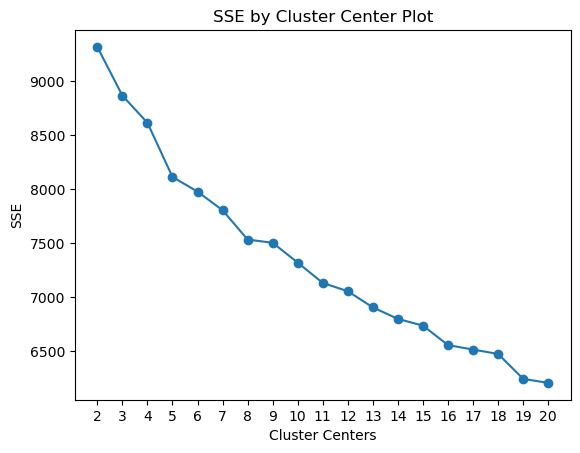

In [174]:
# find optimal number of clusters for min df = 10, max df = 0.95
find_optimal_clusters(preprocessed_context_tfidf_matrix, 20, 1)
# 13 was picked since 7000 SSE was chosen as the maximum SSE

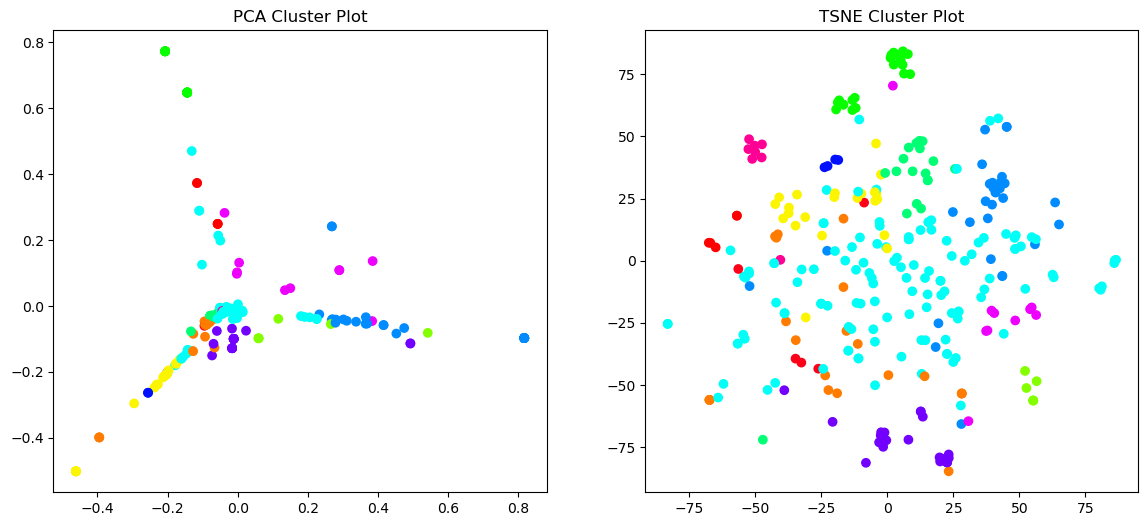

In [173]:
# plot graphs for context 13 clusters min df = 10, max df = 0.95
plot_tsne_pca(preprocessed_context_tfidf_matrix, cluster_labels_context, 250)

In [175]:
get_top_keywords(preprocessed_context_tfidf_matrix, cluster_labels_context, tfidf_vectorizer.get_feature_names_out(), 10)


Cluster 0
appearance,white,speech,remark,cpac,reporter,10,press,news,conference

Cluster 1
rally,event,email,speech,statement,website,mailer,commercial,ad,campaign

Cluster 2
state,texas,tampa,ohio,university,republican,democratic,national,convention,speech

Cluster 3
advertisement,broadcast,commentary,address,talk,comment,program,ad,interview,radio

Cluster 4
georgia,post,website,ad,email,statement,campaign,news,press,release

Cluster 5
vice,iowa,fla,second,senate,gop,democratic,republican,presidential,debate

Cluster 6
unknown,column,state,website,article,facebook,email,comment,statement,post

Cluster 7
newspaper,abc,week,nbc,press,meet,msnbc,television,cnn,interview

Cluster 8
texas,state,comment,debate,remark,representatives,senate,speech,house,floor

Cluster 9
political,air,commercial,newspaper,campaign,web,interview,television,tv,ad

Cluster 10
business,channel,broadcast,hannity,friends,comment,sunday,interview,news,fox

Cluster 11
blog,clinton,college,graphic,day,georgia,post,t

6     4286
7      980
9      737
5      705
2      667
4      666
1      654
3      322
10     314
0      284
8      222
11     213
12     190
Name: preprocessed-context-clustered, dtype: int64

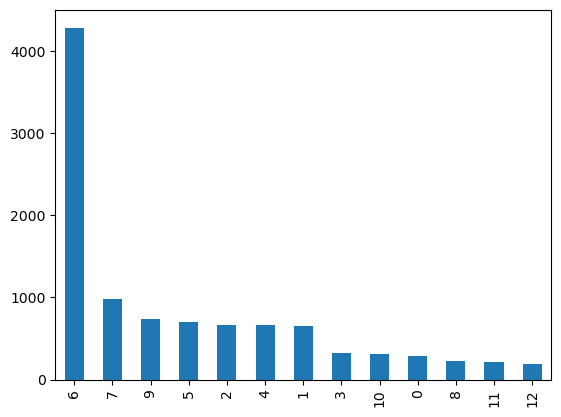

In [176]:
train_data['preprocessed-context-clustered'].value_counts().plot(kind='bar')
train_data['preprocessed-context-clustered'].value_counts()

### JOB TITLE

In [92]:
# preprocess job title
train_data['preprocessed-job-title'] = train_data['job-title'].apply(preprocess_meta_label)
val_data['preprocessed-job-title'] = val_data['job-title'].apply(preprocess_meta_label)
test_data['preprocessed-job-title'] = test_data['job-title'].apply(preprocess_meta_label)

In [143]:
new_col_name = 'job-id-kmeans'
get_kmeans_cluster(train_data, 'preprocessed-job-title', new_col_name=new_col_name, n_clusters = 8)
get_kmeans_cluster(val_data, 'preprocessed-job-title', new_col_name=new_col_name, n_clusters = 8)
get_kmeans_cluster(test_data, 'preprocessed-job-title', new_col_name=new_col_name, n_clusters = 8)

In [145]:
test_data.head()

index          id       label  \
0      0  11972.json        true   
1      1  11685.json       false   
2      2  11096.json       false   
3      3   5209.json   half-true   
4      4   9524.json  pants-fire   

                                           statement  \
0  Building a wall on the U.S.-Mexico border will...   
1  Wisconsin is on pace to double the number of l...   
2  Says John McCain has done nothing to help the ...   
3  Suzanne Bonamici supports a plan that will cut...   
4  When asked by a reporter whether hes at the ce...   

                                             subject  \
0                                        immigration   
1                                               jobs   
2                    military,veterans,voting-record   
3  medicare,message-machine-2012,campaign-adverti...   
4  campaign-finance,legal-issues,campaign-adverti...   

                            speaker             job-title       party  \
0                        rick-perry              Governor  republican   
1                 katrina-shankland  State representative    democrat   
2                      donald-trump       President-Elect  republican   
3                     rob-cornilles            consultant  republican   
4  state-democratic-party-wisconsin               unknown    democrat   

   barely-true-counts  false-counts  half-true-counts  mostly-true-counts  \
0                  30            30                42                  23   
1                   2             1                 0                   0   
2                  63           114                51                  37   
3                   1             1                 3                   1   
4                   5             7                 2                   2   

   pants-on-fire-counts                       context  output  \
0                    18               Radio interview       3   
1                     0             a news conference      -2   
2                    61  comments on ABC's This Week.      -2   
3                     1                  a radio show       1   
4                     7                   a web video      -3   

  preprocessed-job-title preprocessed-context  preprocessed-context-clustered  \
0               governor      radio interview                              10   
1   state representative      news conference                               2   
2        President Elect     comment ABC Week                               2   
3             consultant                radio                               2   
4                unknown            web video                              11   

   preprocessed-job-title-clustered  
0                                 3  
1                                 5  
2                                 4  
3                                 0  
4                                 1

#### EXPLORATORY PROGRAMMING for JOB-TITLE

In [211]:
tfidf_vectorizer = TfidfVectorizer(min_df = 5,
                                   max_df = 0.95,
                                   stop_words = 'english',
                                   lowercase = True)

jobtitle_tfidf_matrix_train = tfidf_vectorizer.fit_transform(train_data['preprocessed-job-title'].str.lower())
# jobtitle_tfidf_matrix_val = tfidf_vectorizer.fit_transform(val_data['preprocessed-job-title'].str.lower())
# jobtitle_tfidf_matrix_test = tfidf_vectorizer.fit_transform(test_data['preprocessed-job-title'].str.lower())

kmeans_job = KMeans(n_clusters = 8, random_state=42, n_init=10)
kmeans_job.fit(jobtitle_tfidf_matrix_train)
# kmeans.fit(jobtitle_tfidf_matrix_val)
# kmeans.fit(jobtitle_tfidf_matrix_test)

cluster_labels_jobtitle_train = kmeans_job.predict(jobtitle_tfidf_matrix_train)
jobtitle_cluster_mapping_train = dict(zip(train_data['preprocessed-job-title'], cluster_labels_jobtitle_train))

# cluster_labels_jobtitle_val = kmeans.predict(jobtitle_tfidf_matrix_val)
# jobtitle_cluster_mapping_val = dict(zip(val_data['preprocessed-job-title'], cluster_labels_jobtitle_val))
#
# cluster_labels_jobtitle_test = kmeans.predict(jobtitle_tfidf_matrix_test)
# jobtitle_cluster_mapping_test = dict(zip(test_data['preprocessed-job-title'], cluster_labels_jobtitle_test))

# create new column with clustered job title labels
# train_data['preprocessed-job-title-clustered'] = train_data['preprocessed-job-title'].map(jobtitle_cluster_mapping_train)

In [100]:
train_data

index          id        label  \
0          0   2635.json        false   
1          1  10540.json    half-true   
2          2    324.json  mostly-true   
3          3   1123.json        false   
4          4   9028.json    half-true   
...      ...         ...          ...   
10235  10235   5473.json  mostly-true   
10236  10236   3408.json  mostly-true   
10237  10237   3959.json    half-true   
10238  10238   2253.json        false   
10239  10239   1155.json   pants-fire   

                                               statement  \
0      Says the Annies List political group supports ...   
1      When did the decline of coal start? It started...   
2      Hillary Clinton agrees with John McCain "by vo...   
3      Health care reform legislation is likely to ma...   
4      The economic turnaround started at the end of ...   
...                                                  ...   
10235  There are a larger number of shark attacks in ...   
10236  Democrats have now become the party of the [At...   
10237  Says an alternative to Social Security that op...   
10238  On lifting the U.S. Cuban embargo and allowing...   
10239  The Department of Veterans Affairs has a manua...   

                                  subject         speaker  \
0                                abortion    dwayne-bohac   
1      energy,history,job-accomplishments  scott-surovell   
2                          foreign-policy    barack-obama   
3                             health-care    blog-posting   
4                            economy,jobs   charlie-crist   
...                                   ...             ...   
10235                   animals,elections    aclu-florida   
10236                           elections     alan-powell   
10237          retirement,social-security     herman-cain   
10238              florida,foreign-policy     jeff-greene   
10239                health-care,veterans  michael-steele   

                                           job-title       party  \
0                               State representative  republican   
1                                     State delegate    democrat   
2                                          President    democrat   
3                                            unknown        none   
4                                            unknown    democrat   
...                                              ...         ...   
10235                                        unknown        none   
10236                                        unknown  republican   
10237                                        unknown  republican   
10238                                        unknown    democrat   
10239  chairman of the Republican National Committee  republican   

       barely-true-counts  false-counts  ...  pants-on-fire-counts  \
0                     0.0           1.0  ...                   0.0   
1                     0.0           0.0  ...                   0.0   
2                    70.0          71.0  ...                   9.0   
3                     7.0          19.0  ...                  44.0   
4                    15.0           9.0  ...                   2.0   
...                   ...           ...  ...                   ...   
10235                 0.0           1.0  ...                   0.0   
10236                 0.0           0.0  ...                   0.0   
10237                 4.0          11.0  ...                   3.0   
10238                 3.0           1.0  ...                   0.0   
10239                 0.0           1.0  ...                   2.0   

                                                 context  output  \
0                                               a mailer      -2   
1                                        a floor speech.       1   
2                                                 Denver       2   
3                                         a news release      -2   
4                                    an interview on CNN      

Fit 2 clusters
Fit 3 clusters
Fit 4 clusters
Fit 5 clusters
Fit 6 clusters
Fit 7 clusters
Fit 8 clusters
Fit 9 clusters
Fit 10 clusters
Fit 11 clusters
Fit 12 clusters
Fit 13 clusters
Fit 14 clusters
Fit 15 clusters
Fit 16 clusters
Fit 17 clusters
Fit 18 clusters
Fit 19 clusters
Fit 20 clusters


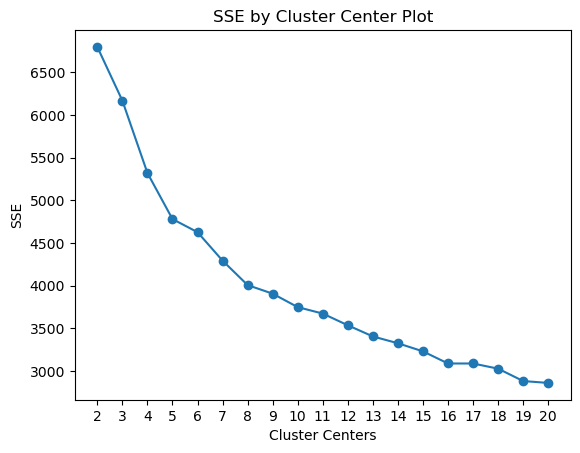

In [188]:
# find optimal number of clusters for min df = 5, max df = 0.95
find_optimal_clusters(jobtitle_tfidf_matrix_train, 20, 1)

In [216]:
# job title with 8 clusters, min df 5, max df 0.95
get_top_keywords(jobtitle_tfidf_matrix_train, kmeans_job.labels_, tfidf_vectorizer.get_feature_names_out(), 1)


Cluster 0
unknown

Cluster 1
president

Cluster 2
house

Cluster 3
governor

Cluster 4
senator

Cluster 5
representative

Cluster 6
elect

Cluster 7
presidential


2    3881
0    2897
4    1171
3     685
1     548
5     525
6     273
7     260
Name: preprocessed-job-title-clustered, dtype: int64

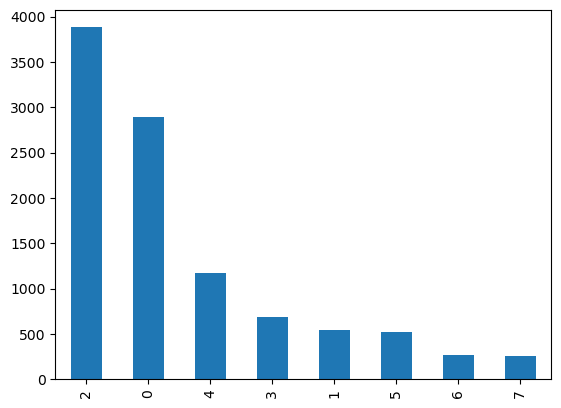

In [183]:
# job-title with 8 clusters, min df 5, max df 0.95
train_data['preprocessed-job-title-clustered'].value_counts().plot(kind='bar')
train_data['preprocessed-job-title-clustered'].value_counts() # preprocessed job title with 8 clusters max df 0.95 in df 5

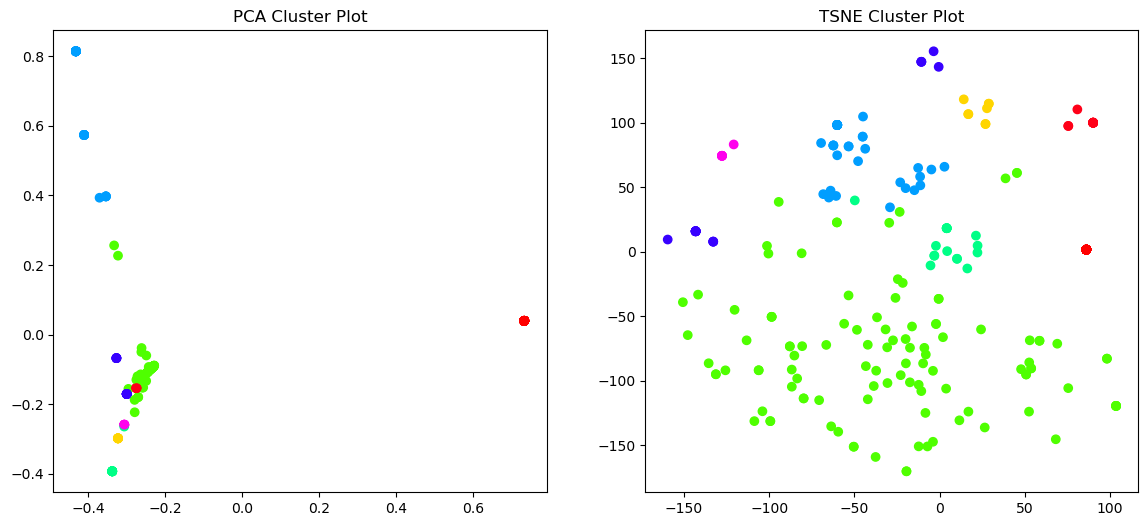

In [189]:
plot_tsne_pca(jobtitle_tfidf_matrix_train, kmeans.labels_, 100)

### PARTY

In [161]:
# preprocess party
train_data['preprocessed-party'] = train_data['party'].apply(preprocess_meta_label)
val_data['preprocessed-party'] = val_data['party'].apply(preprocess_meta_label)
test_data['preprocessed-party'] = test_data['party'].apply(preprocess_meta_label)

In [163]:
# CLUSTER party
new_col_name = 'party-id-kmeans'

get_kmeans_cluster(train_data, 'preprocessed-party', new_col_name=new_col_name, n_clusters = 5)
get_kmeans_cluster(val_data, 'preprocessed-party', new_col_name=new_col_name, n_clusters = 5)
get_kmeans_cluster(test_data, 'preprocessed-party', new_col_name=new_col_name, n_clusters = 5)

In [164]:
test_data['preprocessed-party-clustered'].value_counts()

2    571
1    406
0    249
4     27
3     14
Name: preprocessed-party-clustered, dtype: int64

In [165]:
train_data.head() # FINAL META DATA SET for KMEANS

index          id        label  \
0      0   2635.json        false   
1      1  10540.json    half-true   
2      2    324.json  mostly-true   
3      3   1123.json        false   
4      4   9028.json    half-true   

                                           statement  \
0  Says the Annies List political group supports ...   
1  When did the decline of coal start? It started...   
2  Hillary Clinton agrees with John McCain "by vo...   
3  Health care reform legislation is likely to ma...   
4  The economic turnaround started at the end of ...   

                              subject         speaker             job-title  \
0                            abortion    dwayne-bohac  State representative   
1  energy,history,job-accomplishments  scott-surovell        State delegate   
2                      foreign-policy    barack-obama             President   
3                         health-care    blog-posting               unknown   
4                        economy,jobs   charlie-crist               unknown   

        party  barely-true-counts  false-counts  ...              context  \
0  republican                 0.0           1.0  ...             a mailer   
1    democrat                 0.0           0.0  ...      a floor speech.   
2    democrat                70.0          71.0  ...               Denver   
3        none                 7.0          19.0  ...       a news release   
4    democrat                15.0           9.0  ...  an interview on CNN   

   output               preprocessed-subject preprocessed-context  \
0      -2                           abortion               mailer   
1       1  energy history job accomplishment         floor speech   
2       2                     foreign policy               Denver   
3      -2                        health care         news release   
4       1                        economy job        interview CNN   

   preprocessed-context-clustered preprocessed-job-title preprocessed-party  \
0                               6   state representative         republican   
1                               8         state delegate           democrat   
2                               6              president           democrat   
3                               4                unknown                      
4                               7                unknown           democrat   

   preprocessed-party-clustered preprocessed-job-title-clustered  \
0                             1                                5   
1                             0                                2   
2                             0                                1   
3                             3                                0   
4                             0                                0   

  preprocessed-subject-clustered  
0                              0  
1                              3  
2                              0  
3                              4  
4                              3  

[5 rows x 23 columns]

In [190]:
train_data.head()

index          id        label  \
0      0   2635.json        false   
1      1  10540.json    half-true   
2      2    324.json  mostly-true   
3      3   1123.json        false   
4      4   9028.json    half-true   

                                           statement  \
0  Says the Annies List political group supports ...   
1  When did the decline of coal start? It started...   
2  Hillary Clinton agrees with John McCain "by vo...   
3  Health care reform legislation is likely to ma...   
4  The economic turnaround started at the end of ...   

                              subject         speaker             job-title  \
0                            abortion    dwayne-bohac  State representative   
1  energy,history,job-accomplishments  scott-surovell        State delegate   
2                      foreign-policy    barack-obama             President   
3                         health-care    blog-posting               unknown   
4                        economy,jobs   charlie-crist               unknown   

        party  barely-true-counts  false-counts  ...              context  \
0  republican                 0.0           1.0  ...             a mailer   
1    democrat                 0.0           0.0  ...      a floor speech.   
2    democrat                70.0          71.0  ...               Denver   
3        none                 7.0          19.0  ...       a news release   
4    democrat                15.0           9.0  ...  an interview on CNN   

   output               preprocessed-subject preprocessed-context  \
0      -2                           abortion               mailer   
1       1  energy history job accomplishment         floor speech   
2       2                     foreign policy               Denver   
3      -2                        health care         news release   
4       1                        economy job        interview CNN   

   preprocessed-context-clustered preprocessed-job-title preprocessed-party  \
0                               6   state representative         republican   
1                               8         state delegate           democrat   
2                               6              president           democrat   
3                               4                unknown                      
4                               7                unknown           democrat   

   preprocessed-party-clustered preprocessed-job-title-clustered  \
0                             1                                5   
1                             0                                2   
2                             0                                1   
3                             3                                0   
4                             0                                0   

  preprocessed-subject-clustered  
0                              0  
1                              3  
2                              0  
3                              4  
4                              3  

[5 rows x 23 columns]

#### EXPLORATORY PROGRAMMING for PARTY

In [217]:
# CLUSTER party
tfidf_vectorizer = TfidfVectorizer(min_df = 5,
                                   max_df = 0.95,
                                   stop_words = 'english',
                                   lowercase = True)

preprocessed_party_tfidf_matrix = tfidf_vectorizer.fit_transform(train_data['preprocessed-party'].str.lower())

kmeans_party = KMeans(n_clusters = 5, random_state=42, n_init=10)
kmeans_party.fit(preprocessed_party_tfidf_matrix)

# Map the original party labels to their corresponding clusters
cluster_labels_party = kmeans_party.predict(preprocessed_party_tfidf_matrix)
party_cluster_mapping = dict(zip(train_data['preprocessed-party'], cluster_labels_party))

# # create new column with clustered party labels
# train_data['preprocessed-party-clustered'] = train_data['preprocessed-party'].map(party_cluster_mapping)

Fit 2 clusters
Fit 3 clusters
Fit 4 clusters
Fit 5 clusters
Fit 6 clusters
Fit 7 clusters
Fit 8 clusters
Fit 9 clusters
Fit 10 clusters
Fit 11 clusters
Fit 12 clusters
Fit 13 clusters
Fit 14 clusters
Fit 15 clusters


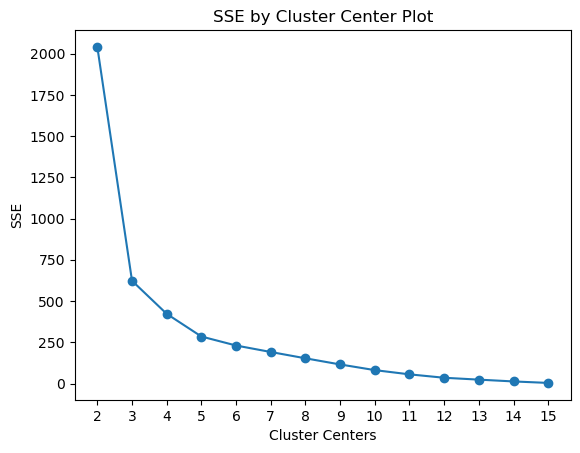

In [201]:
# party_tfidf_matrix = tfidf_vectorizer.fit_transform(train_data['preprocessed-party'].str.lower())
find_optimal_clusters(preprocessed_party_tfidf_matrix, 15, 1)

In [218]:
# get top keywords for party
get_top_keywords(preprocessed_party_tfidf_matrix, kmeans.labels_, tfidf_vectorizer.get_feature_names_out(), 1)


Cluster 0
democrat

Cluster 1
republican

Cluster 2
organization

Cluster 3
newsmaker

Cluster 4
independent


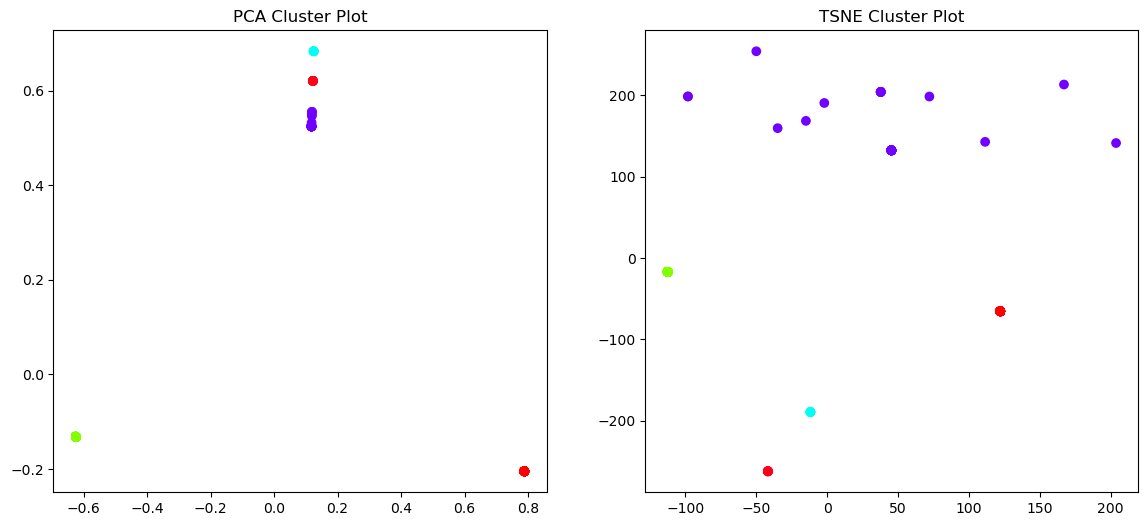

In [220]:
# plot tsne pca for party
plot_tsne_pca(preprocessed_party_tfidf_matrix, cluster_labels_party, 19)

1    4497
0    3336
3    2041
2     219
4     147
Name: preprocessed-party-clustered, dtype: int64

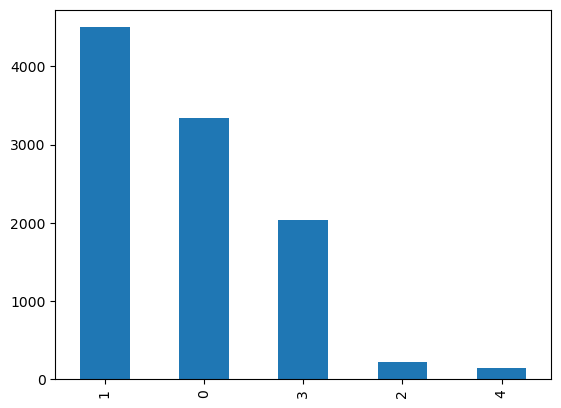

In [221]:
train_data['preprocessed-party-clustered'].value_counts().plot(kind='bar')
train_data['preprocessed-party-clustered'].value_counts()

### SUBJECT

In [158]:
train_data['preprocessed-subject'] = train_data['subject'].apply(preprocess_meta_label)
val_data['preprocessed-subject'] = val_data['subject'].apply(preprocess_meta_label)
test_data['preprocessed-subject'] = test_data['subject'].apply(preprocess_meta_label)

In [159]:
# CLUSTER PREPROCESSED SUBJECT
new_col_name = 'subject-id-kmeans'
get_kmeans_cluster(train_data, 'preprocessed-subject', new_col_name=new_col_name, 14)
get_kmeans_cluster(val_data, 'preprocessed-subject', new_col_name=new_col_name, 14)
get_kmeans_cluster(test_data, 'preprocessed-subject', new_col_name=new_col_name, 14)

#### EXPLORATORY PROGRAMMING for SUBJECT

In [224]:
# CLUSTER PREPROCESSED SUBJECT
# Create tf-df matrix for subject labels
tfidf_vectorizer = TfidfVectorizer(min_df = 5,
                                   max_df = 0.95,
                                   stop_words='english',
                                   lowercase=True)

preprocessed_subject_tfidf_matrix = tfidf_vectorizer.fit_transform(train_data['preprocessed-subject'])

# Cluster using k-means
kmeans_subject = KMeans(n_clusters=14, random_state=42, n_init=10)
kmeans_subject.fit(preprocessed_subject_tfidf_matrix)

# map original subject labels to corresponding clusters
preprocessed_subject_cluster_labels = kmeans_subject.predict(preprocessed_subject_tfidf_matrix)
preprocessed_subject_cluster_mapping = dict(zip(train_data['preprocessed-subject'], preprocessed_subject_cluster_labels))

# create new column with clustered subject labels
# train_data['preprocessed-subject-clustered'] = train_data['preprocessed-subject'].map(preprocessed_subject_cluster_mapping)

Fit 2 clusters
Fit 3 clusters
Fit 4 clusters
Fit 5 clusters
Fit 6 clusters
Fit 7 clusters
Fit 8 clusters
Fit 9 clusters
Fit 10 clusters
Fit 11 clusters
Fit 12 clusters
Fit 13 clusters
Fit 14 clusters
Fit 15 clusters
Fit 16 clusters
Fit 17 clusters
Fit 18 clusters
Fit 19 clusters
Fit 20 clusters


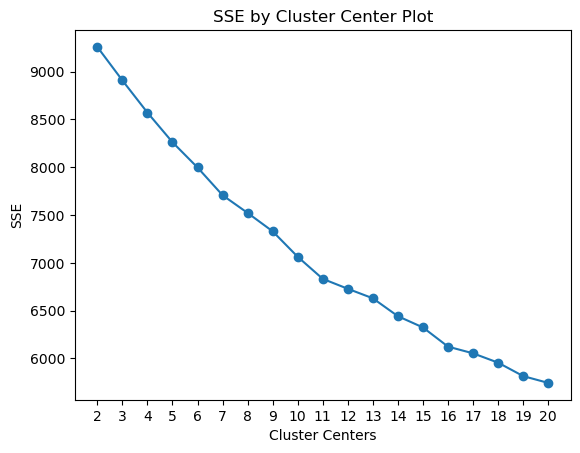

In [225]:
# find optimal clusters for preprocessed subject max df 0.95
find_optimal_clusters(preprocessed_subject_tfidf_matrix, 20, 1)

In [227]:
# get top keywords for preprocessed
get_top_keywords(preprocessed_subject_tfidf_matrix, preprocessed_subject_cluster_labels, tfidf_vectorizer.get_feature_names_out(), 2)


Cluster 0
policy,foreign

Cluster 1
economy,taxis

Cluster 2
budget,federal

Cluster 3
economy,job

Cluster 4
care,health

Cluster 5
machine,message

Cluster 6
budget,state

Cluster 7
child,education

Cluster 8
campaign,election

Cluster 9
crime,immigration

Cluster 10
candidate,biography

Cluster 11
policy,military

Cluster 12
energy,environment

Cluster 13
crime,gun


0     3585
4      926
3      885
6      694
2      623
10     549
5      472
1      441
8      434
9      414
7      376
12     296
13     281
11     264
Name: preprocessed-subject-clustered, dtype: int64

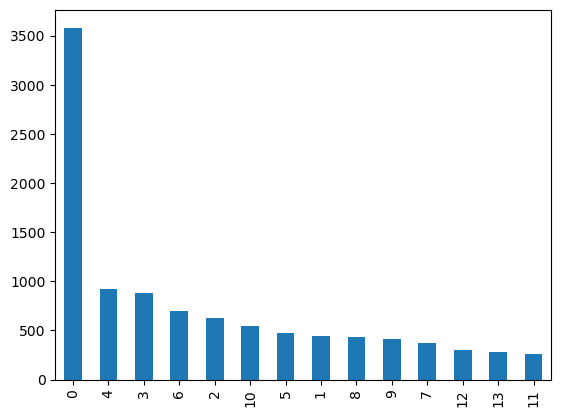

In [228]:
train_data['preprocessed-subject-clustered'].value_counts().plot(kind='bar')
train_data['preprocessed-subject-clustered'].value_counts()

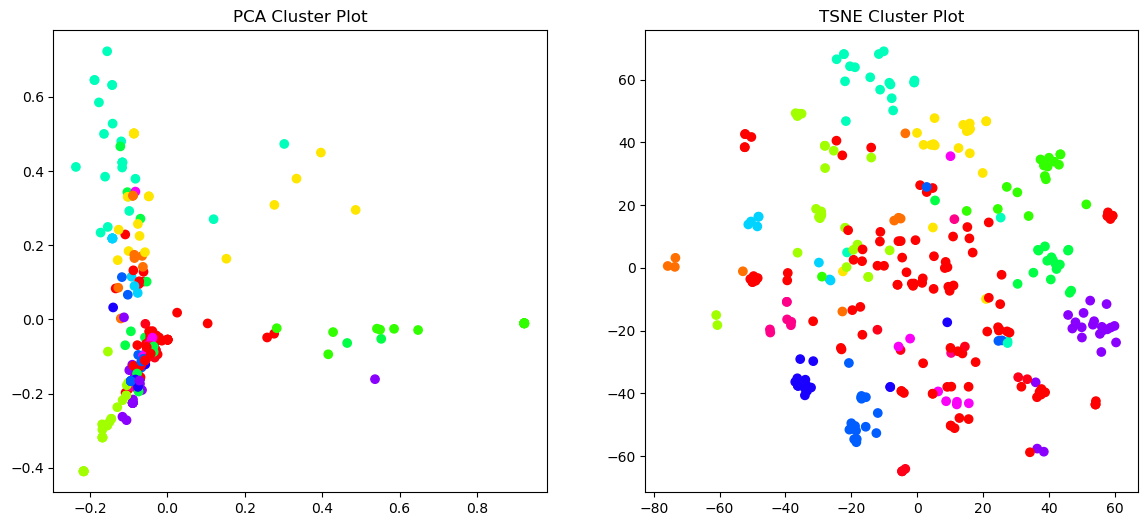

In [229]:
# plot tsne pca for preprocessed subject
plot_tsne_pca(preprocessed_subject_tfidf_matrix, preprocessed_subject_cluster_labels, 50)

In [231]:
train_data

index          id        label  \
0          0   2635.json        false   
1          1  10540.json    half-true   
2          2    324.json  mostly-true   
3          3   1123.json        false   
4          4   9028.json    half-true   
...      ...         ...          ...   
10235  10235   5473.json  mostly-true   
10236  10236   3408.json  mostly-true   
10237  10237   3959.json    half-true   
10238  10238   2253.json        false   
10239  10239   1155.json   pants-fire   

                                               statement  \
0      Says the Annies List political group supports ...   
1      When did the decline of coal start? It started...   
2      Hillary Clinton agrees with John McCain "by vo...   
3      Health care reform legislation is likely to ma...   
4      The economic turnaround started at the end of ...   
...                                                  ...   
10235  There are a larger number of shark attacks in ...   
10236  Democrats have now become the party of the [At...   
10237  Says an alternative to Social Security that op...   
10238  On lifting the U.S. Cuban embargo and allowing...   
10239  The Department of Veterans Affairs has a manua...   

                                  subject         speaker  \
0                                abortion    dwayne-bohac   
1      energy,history,job-accomplishments  scott-surovell   
2                          foreign-policy    barack-obama   
3                             health-care    blog-posting   
4                            economy,jobs   charlie-crist   
...                                   ...             ...   
10235                   animals,elections    aclu-florida   
10236                           elections     alan-powell   
10237          retirement,social-security     herman-cain   
10238              florida,foreign-policy     jeff-greene   
10239                health-care,veterans  michael-steele   

                                           job-title       party  \
0                               State representative  republican   
1                                     State delegate    democrat   
2                                          President    democrat   
3                                            unknown        none   
4                                            unknown    democrat   
...                                              ...         ...   
10235                                        unknown        none   
10236                                        unknown  republican   
10237                                        unknown  republican   
10238                                        unknown    democrat   
10239  chairman of the Republican National Committee  republican   

       barely-true-counts  false-counts  ...  \
0                     0.0           1.0  ...   
1                     0.0           0.0  ...   
2                    70.0          71.0  ...   
3                     7.0          19.0  ...   
4                    15.0           9.0  ...   
...                   ...           ...  ...   
10235                 0.0           1.0  ...   
10236                 0.0           0.0  ...   
10237                 4.0          11.0  ...   
10238                 3.0           1.0  ...   
10239                 0.0           1.0  ...   

                                                 context  output  \
0                                               a mailer      -2   
1                                        a floor speech.       1   
2                                                 Denver       2   
3                                         a news release      -2   
4                                    an interview on CNN       1   
...                                                  ...     ...   
10235                  interview on "The Colbert Report"       2   
10236                                       an interview       2   
10237                   a Republican presidential deba

In [49]:
train_data.head()

index          id        label  \
0      0   2635.json        false   
1      1  10540.json    half-true   
2      2    324.json  mostly-true   
3      3   1123.json        false   
4      4   9028.json    half-true   

                                           statement  \
0  Says the Annies List political group supports ...   
1  When did the decline of coal start? It started...   
2  Hillary Clinton agrees with John McCain "by vo...   
3  Health care reform legislation is likely to ma...   
4  The economic turnaround started at the end of ...   

                              subject         speaker             job-title  \
0                            abortion    dwayne-bohac  State representative   
1  energy,history,job-accomplishments  scott-surovell        State delegate   
2                      foreign-policy    barack-obama             President   
3                         health-care    blog-posting               unknown   
4                        economy,jobs   charlie-crist               unknown   

        party  barely-true-counts  false-counts  ...  \
0  republican                 0.0           1.0  ...   
1    democrat                 0.0           0.0  ...   
2    democrat                70.0          71.0  ...   
3        none                 7.0          19.0  ...   
4    democrat                15.0           9.0  ...   

   preprocessed-party-clustered  preprocessed-job-title-clustered  \
0                             1                                 5   
1                             0                                 2   
2                             0                                 1   
3                             3                                 0   
4                             0                                 0   

   preprocessed-subject-clustered  \
0                               0   
1                               3   
2                               0   
3                               4   
4                               3   

                                         pos-id-fine  \
0  [9, 16, 16, 12, 1, 10, 9, 1, 16, 10, 11, 16, 1...   
1  [16, 5, 16, 10, 16, 10, 10, 16, 16, 5, 16, 1, ...   
2  [12, 12, 9, 16, 12, 12, 16, 16, 6, 16, 4, 12, ...   
3   [10, 10, 10, 10, 9, 1, 16, 4, 1, 10, 10, 11, 16]   
4         [16, 1, 10, 5, 16, 16, 10, 16, 16, 10, 16]   

                                  pos-id-fine-merged  \
0         [2, 5, 5, 3, 1, 3, 2, 1, 5, 3, 3, 5, 3, 5]   
1  [5, 2, 5, 3, 5, 3, 3, 5, 5, 2, 5, 1, 3, 2, 5, ...   
2  [3, 3, 2, 5, 3, 3, 5, 5, 2, 5, 2, 3, 3, 5, 3, ...   
3            [3, 3, 3, 3, 2, 1, 5, 2, 1, 3, 3, 3, 5]   
4                  [5, 1, 3, 2, 5, 5, 3, 5, 5, 3, 5]   

                                       pos-id-custom  \
0      [2, 15, 9, 9, 3, 1, 2, 3, 11, 1, 1, 5, 1, 11]   
1  [8, 2, 15, 1, 5, 1, 1, 11, 6, 2, 8, 3, 1, 2, 5...   
2  [9, 9, 2, 5, 9, 9, 11, 5, 2, 13, 2, 9, 9, 15, ...   
3         [1, 1, 1, 1, 12, 3, 13, 2, 3, 1, 1, 1, 11]   
4               [15, 3, 1, 2, 5, 15, 1, 5, 6, 1, 11]   

                                         dep-id-fine  \
0         [8, 8, 4, 4, 3, 1, 8, 3, 8, 7, 2, 8, 8, 8]   
1  [8, 8, 8, 1, 8, 7, 8, 8, 1, 8, 8, 3, 1, 8, 8, ...   
2  [7, 1, 8, 8, 7, 8, 8, 8, 8, 8, 8, 7, 8, 8, 2, ...   
3            [7, 7, 7, 1, 8, 8, 8, 8, 3, 7, 7, 2, 8]   
4                  [8, 3, 1, 8, 8, 8, 8, 8, 8, 8, 8]   

                                       dep-id-custom  \
0      [7, 5, 11, 11, 8, 6, 11, 8, 1, 4, 9, 2, 3, 1]   
1  [11, 7, 5, 6, 2, 4, 3, 1, 6, 7, 11, 8, 6, 11, ...   
2  [4, 6, 7, 2, 4, 3, 1, 2, 11, 10, 11, 4, 11, 5,...   
3         [4, 4, 4, 6, 7, 11, 10, 11, 8, 4, 4, 9, 1]   
4                 [5, 8, 6, 7, 2, 5, 3, 2, 11, 3, 1]   

                                 statement-customswr  \
0  say annies list political group support third ...   
1  when do decline coal start start when natural ...   
2  hillary clinton agree john mccain vote give ge...   
3  health care reform legislation be likely manda...   
4                 economic t

In [54]:
train_data['subject-id-kmeans']

0        0
1        3
2        0
3        4
4        3
        ..
10235    8
10236    8
10237    0
10238    0
10239    4
Name: subject-id-kmeans, Length: 10240, dtype: int32

## CLUSTER META DATA WITH JACCARD

In [60]:
def jaccard_similarity(label1, label2):
    set1 = set(label1)
    set2 = set(label2)

    # If both sets are empty, consider non-matching
    if not set1 and not set2:
        return 1

    intersection = set1.intersection(set2)
    union = set1.union(set2)
    return len(intersection) / len(union)

In [62]:
def get_meta_id(metadata, frequent_meta, threshold):
    if isinstance(metadata, str):
        # preprocessed_meta = preprocess_meta_label(metadata)
        matched = [m for m in frequent_meta if isinstance(m, str) and jaccard_similarity(m, metadata) >= threshold]

        if len(matched) > 0:
            return frequent_meta[matched[0]]
        else:
            return len(set(frequent_meta.values()))
    else:
        return len(set(frequent_meta.values()))

In [67]:
# JOB_TITLE_ID
frequent_jobs_list = train_data['preprocessed-job-title'].value_counts()[:8]
frequent_jobs = {job: idx for idx, job in enumerate(frequent_jobs_list.reset_index()['index'].tolist())}
THRESHOLD_JOB = 0.5

train_data['job-id-jaccard'] = train_data['preprocessed-job-title'].apply(lambda x: get_meta_id(x,
                                                                           frequent_jobs,
                                                                           THRESHOLD_JOB))
val_data['job-id-jaccard'] = val_data['preprocessed-job-title'].apply(lambda x: get_meta_id(x,
                                                                       frequent_jobs,
                                                                       THRESHOLD_JOB))
test_data['job-id-jaccard'] = test_data['preprocessed-job-title'].apply(lambda x: get_meta_id(x,
                                                                         frequent_jobs,
                                                                         THRESHOLD_JOB))

print('number of job labels: ', len(set(frequent_jobs.values())))
print(frequent_jobs)
train_data['job-id-jaccard'].value_counts()

number of job labels:  8
{'unknown': 0, 'governor': 1, 'president': 2, 'U.S. Senator': 3, 'President Elect': 4, 'U.S. senator': 5, 'presidential candidate': 6, 'state senator': 7}


0    2897
3    1908
2    1521
8    1449
1     881
6     721
4     353
5     275
7     235
Name: job-id-jaccard, dtype: int64

In [71]:
print(frequent_jobs_list)

unknown                   2897
governor                   606
president                  523
U.S. Senator               480
President Elect            273
U.S. senator               267
presidential candidate     255
state senator              201
Name: preprocessed-job-title, dtype: int64


In [68]:
train_data.head()

index          id        label  \
0      0   2635.json        false   
1      1  10540.json    half-true   
2      2    324.json  mostly-true   
3      3   1123.json        false   
4      4   9028.json    half-true   

                                           statement  \
0  Says the Annies List political group supports ...   
1  When did the decline of coal start? It started...   
2  Hillary Clinton agrees with John McCain "by vo...   
3  Health care reform legislation is likely to ma...   
4  The economic turnaround started at the end of ...   

                              subject         speaker             job-title  \
0                            abortion    dwayne-bohac  State representative   
1  energy,history,job-accomplishments  scott-surovell        State delegate   
2                      foreign-policy    barack-obama             President   
3                         health-care    blog-posting               unknown   
4                        economy,jobs   charlie-crist               unknown   

        party  barely-true-counts  false-counts  ...  job-title-id-kmeans  \
0  republican                 0.0           1.0  ...                    5   
1    democrat                 0.0           0.0  ...                    2   
2    democrat                70.0          71.0  ...                    1   
3        none                 7.0          19.0  ...                    0   
4    democrat                15.0           9.0  ...                    0   

   subject-id-kmeans                                        pos-id-fine  \
0                  0  [9, 16, 16, 12, 1, 10, 9, 1, 16, 10, 11, 16, 1...   
1                  3  [16, 5, 16, 10, 16, 10, 10, 16, 16, 5, 16, 1, ...   
2                  0  [12, 12, 9, 16, 12, 12, 16, 16, 6, 16, 4, 12, ...   
3                  4   [10, 10, 10, 10, 9, 1, 16, 4, 1, 10, 10, 11, 16]   
4                  3         [16, 1, 10, 5, 16, 16, 10, 16, 16, 10, 16]   

                                  pos-id-fine-merged  \
0         [2, 5, 5, 3, 1, 3, 2, 1, 5, 3, 3, 5, 3, 5]   
1  [5, 2, 5, 3, 5, 3, 3, 5, 5, 2, 5, 1, 3, 2, 5, ...   
2  [3, 3, 2, 5, 3, 3, 5, 5, 2, 5, 2, 3, 3, 5, 3, ...   
3            [3, 3, 3, 3, 2, 1, 5, 2, 1, 3, 3, 3, 5]   
4                  [5, 1, 3, 2, 5, 5, 3, 5, 5, 3, 5]   

                                       pos-id-custom  \
0      [2, 15, 9, 9, 3, 1, 2, 3, 11, 1, 1, 5, 1, 11]   
1  [8, 2, 15, 1, 5, 1, 1, 11, 6, 2, 8, 3, 1, 2, 5...   
2  [9, 9, 2, 5, 9, 9, 11, 5, 2, 13, 2, 9, 9, 15, ...   
3         [1, 1, 1, 1, 12, 3, 13, 2, 3, 1, 1, 1, 11]   
4               [15, 3, 1, 2, 5, 15, 1, 5, 6, 1, 11]   

                                         dep-id-fine  \
0         [8, 8, 4, 4, 3, 1, 8, 3, 8, 7, 2, 8, 8, 8]   
1  [8, 8, 8, 1, 8, 7, 8, 8, 1, 8, 8, 3, 1, 8, 8, ...   
2  [7, 1, 8, 8, 7, 8, 8, 8, 8, 8, 8, 7, 8, 8, 2, ...   
3            [7, 7, 7, 1, 8, 8, 8, 8, 3, 7, 7, 2, 8]   
4                  [8, 3, 1, 8, 8, 8, 8, 8, 8, 8, 8]   

                                       dep-id-custom  \
0      [7, 5, 11, 11, 8, 6, 11, 8, 1, 4, 9, 2, 3, 1]   
1  [11, 7, 5, 6, 2, 4, 3, 1, 6, 7, 11, 8, 6, 11, ...   
2  [4, 6, 7, 2, 4, 3, 1, 2, 11, 10, 11, 4, 11, 5,...   
3         [4, 4, 4, 6, 7, 11, 10, 11, 8, 4, 4, 9, 1]   
4                 [5, 8, 6, 7, 2, 5, 3, 2, 11, 3, 1]   

                                 statement-customswr  \
0  say annies list political group support third ...   
1  when do decline coal start start when natural ...   
2  hillary clinton agree john mccain vote give ge...   
3  health care reform legislation be likely manda...   
4                 economic turnaround start end term   

                                  statement-spacyswr job-id-jaccard  
0  say annies list political group support trimes...              2  
1  decline coal start start natural gas take star...              6  
2  hillary clinton agree john mccain vote george ...              2  
3  health care reform legislation likely mandate ...              0  
4                 e

In [69]:
# PARTY_ID
frequent_parties_list = train_data['preprocessed-party'].value_counts()[:5]
frequent_parties = {party: idx for idx, party in enumerate(frequent_parties_list.reset_index()['index'].tolist())}

THRESHOLD_PARTY = 0.5

train_data['party-id-jaccard'] = train_data['preprocessed-party'].apply(lambda x: get_meta_id(x,
                                                                         frequent_parties,
                                                                         THRESHOLD_PARTY))
val_data['party-id-jaccard'] = val_data['preprocessed-party'].apply(lambda x: get_meta_id(x,
                                                                     frequent_parties,
                                                                     THRESHOLD_PARTY))
test_data['party-id-jaccard'] = test_data['preprocessed-party'].apply(lambda x: get_meta_id(x,
                                                                       frequent_parties,
                                                                       THRESHOLD_PARTY))

print('number of party labels: ', len(set(frequent_parties.values())))
print(frequent_parties)
print(frequent_parties_list)
train_data['party-id-jaccard'].value_counts()

number of party labels:  5
{'republican': 0, 'democrat': 1, '': 2, 'organization': 3, 'independent': 4}
republican      4497
democrat        3336
                1744
organization     219
independent      147
Name: preprocessed-party, dtype: int64


0    4547
1    3338
2    1744
3     257
5     207
4     147
Name: party-id-jaccard, dtype: int64

In [70]:
train_data.head()

index          id        label  \
0      0   2635.json        false   
1      1  10540.json    half-true   
2      2    324.json  mostly-true   
3      3   1123.json        false   
4      4   9028.json    half-true   

                                           statement  \
0  Says the Annies List political group supports ...   
1  When did the decline of coal start? It started...   
2  Hillary Clinton agrees with John McCain "by vo...   
3  Health care reform legislation is likely to ma...   
4  The economic turnaround started at the end of ...   

                              subject         speaker             job-title  \
0                            abortion    dwayne-bohac  State representative   
1  energy,history,job-accomplishments  scott-surovell        State delegate   
2                      foreign-policy    barack-obama             President   
3                         health-care    blog-posting               unknown   
4                        economy,jobs   charlie-crist               unknown   

        party  barely-true-counts  false-counts  ...  subject-id-kmeans  \
0  republican                 0.0           1.0  ...                  0   
1    democrat                 0.0           0.0  ...                  3   
2    democrat                70.0          71.0  ...                  0   
3        none                 7.0          19.0  ...                  4   
4    democrat                15.0           9.0  ...                  3   

                                         pos-id-fine  \
0  [9, 16, 16, 12, 1, 10, 9, 1, 16, 10, 11, 16, 1...   
1  [16, 5, 16, 10, 16, 10, 10, 16, 16, 5, 16, 1, ...   
2  [12, 12, 9, 16, 12, 12, 16, 16, 6, 16, 4, 12, ...   
3   [10, 10, 10, 10, 9, 1, 16, 4, 1, 10, 10, 11, 16]   
4         [16, 1, 10, 5, 16, 16, 10, 16, 16, 10, 16]   

                                  pos-id-fine-merged  \
0         [2, 5, 5, 3, 1, 3, 2, 1, 5, 3, 3, 5, 3, 5]   
1  [5, 2, 5, 3, 5, 3, 3, 5, 5, 2, 5, 1, 3, 2, 5, ...   
2  [3, 3, 2, 5, 3, 3, 5, 5, 2, 5, 2, 3, 3, 5, 3, ...   
3            [3, 3, 3, 3, 2, 1, 5, 2, 1, 3, 3, 3, 5]   
4                  [5, 1, 3, 2, 5, 5, 3, 5, 5, 3, 5]   

                                       pos-id-custom  \
0      [2, 15, 9, 9, 3, 1, 2, 3, 11, 1, 1, 5, 1, 11]   
1  [8, 2, 15, 1, 5, 1, 1, 11, 6, 2, 8, 3, 1, 2, 5...   
2  [9, 9, 2, 5, 9, 9, 11, 5, 2, 13, 2, 9, 9, 15, ...   
3         [1, 1, 1, 1, 12, 3, 13, 2, 3, 1, 1, 1, 11]   
4               [15, 3, 1, 2, 5, 15, 1, 5, 6, 1, 11]   

                                         dep-id-fine  \
0         [8, 8, 4, 4, 3, 1, 8, 3, 8, 7, 2, 8, 8, 8]   
1  [8, 8, 8, 1, 8, 7, 8, 8, 1, 8, 8, 3, 1, 8, 8, ...   
2  [7, 1, 8, 8, 7, 8, 8, 8, 8, 8, 8, 7, 8, 8, 2, ...   
3            [7, 7, 7, 1, 8, 8, 8, 8, 3, 7, 7, 2, 8]   
4                  [8, 3, 1, 8, 8, 8, 8, 8, 8, 8, 8]   

                                       dep-id-custom  \
0      [7, 5, 11, 11, 8, 6, 11, 8, 1, 4, 9, 2, 3, 1]   
1  [11, 7, 5, 6, 2, 4, 3, 1, 6, 7, 11, 8, 6, 11, ...   
2  [4, 6, 7, 2, 4, 3, 1, 2, 11, 10, 11, 4, 11, 5,...   
3         [4, 4, 4, 6, 7, 11, 10, 11, 8, 4, 4, 9, 1]   
4                 [5, 8, 6, 7, 2, 5, 3, 2, 11, 3, 1]   

                                 statement-customswr  \
0  say annies list political group support third ...   
1  when do decline coal start start when natural ...   
2  hillary clinton agree john mccain vote give ge...   
3  health care reform legislation be likely manda...   
4                 economic turnaround start end term   

                                  statement-spacyswr job-id-jaccard  \
0  say annies list political group support trimes...              2   
1  decline coal start start natural gas take star...              6   
2  hillary clinton agree john mccain vote george ...              2   
3  health care reform legislation likely mandate ...              0   
4                 economic turnaround start end term              0   

  party-id-jaccard  
0                0  
1                1  
2    

In [ ]:
print(train_data['party_id'].dtypes)

int64


In [ ]:
train_data['party_id'].value_counts()

0     4551
1     3349
2     1744
3      257
4      147
7       59
5       56
10      42
8       35
Name: party_id, dtype: int64

In [ ]:
# # SPEAKER_ID
# THRESHOLD_SPEAKER = 0.5
# frequent_speakers_list = train_data['speaker'].str.lower().value_counts()[:25]
# frequent_speakers = {speaker: idx for idx, speaker in enumerate(frequent_speakers_list.reset_index()['index'].tolist())}
#
# train_data['speaker-id-jaccard'] = train_data['speaker'].apply(lambda x: get_meta_id(x,
#                                                                              frequent_speakers,
#                                                                              THRESHOLD_SPEAKER))
# val_data['speaker-id-jaccard'] = val_data['speaker'].apply(lambda x: get_meta_id(x,
#                                                                          frequent_speakers,
#                                                                          THRESHOLD_SPEAKER))
# test_data['speaker-id'] = test_data['speaker'].apply(lambda x: get_meta_id(x,
#                                                                            frequent_speakers,
#                                                                            THRESHOLD_SPEAKER))
#
# print('number of speaker labels: ', len(set(frequent_speakers.values())))
# print(frequent_speakers)
# train_data['speaker_id'].value_counts()

number of speaker labels:  25
{'barack-obama': 0, 'donald-trump': 1, 'hillary-clinton': 2, 'mitt-romney': 3, 'scott-walker': 4, 'john-mccain': 5, 'rick-perry': 6, 'chain-email': 7, 'marco-rubio': 8, 'rick-scott': 9, 'ted-cruz': 10, 'bernie-s': 11, 'chris-christie': 12, 'facebook-posts': 13, 'charlie-crist': 14, 'newt-gingrich': 15, 'joe-biden': 16, 'jeb-bush': 17, 'blog-posting': 18, 'paul-ryan': 19, 'sarah-palin': 20, 'john-boehner': 21, 'michele-bachmann': 22, 'rick-santorum': 23, 'national-republican-congressional-committee': 24}


2     2041
25    1557
1     1382
0      962
4      721
3      473
7      449
11     342
5      285
6      255
16     237
12     181
14     172
21     150
24     130
10     129
9      127
8      120
23     109
18     102
17      98
19      68
15      43
20      43
13      36
22      28
Name: speaker_id, dtype: int64

In [ ]:
# # STATE_INFO_ID
# frequent_states_list = train_data['state_info'].str.lower().value_counts()[:20]
# frequent_states = {state: idx for idx, state in enumerate(frequent_states_list.reset_index()['index'].tolist())}
#
# THRESHOLD_STATE = 0.5
#
# train_data['state-id-jaccard'] = train_data['state_info'].apply(lambda x: get_meta_id(x,
#                                                                               frequent_states,
#                                                                               THRESHOLD_STATE))
# val_data['state-id-jaccard'] = val_data['state_info'].apply(lambda x: get_meta_id(x,
#                                                                           frequent_states,
#                                                                           THRESHOLD_STATE))
# test_data['state-id-jaccard'] = test_data['state_info'].apply(lambda x: get_meta_id(x,
#                                                                             frequent_states,
#                                                                             THRESHOLD_STATE))
#
# print('number of state labels: ', len(set(frequent_states.values())))
# print(frequent_states)
# train_data['state_id'].value_counts()

number of state labels:  20
{'': 0, 'texas': 1, 'florida': 2, 'wisconsin': 3, 'new york': 4, 'illinois': 5, 'ohio': 6, 'georgia': 7, 'virginia': 8, 'rhode island': 9, 'new jersey': 10, 'oregon': 11, 'massachusetts': 12, 'arizona': 13, 'california': 14, 'washington, d.c.': 15, 'vermont': 16, 'pennsylvania': 17, 'new hampshire': 18, 'arkansas': 19}


0     2208
2     1577
3     1444
4     1144
1     1086
7     1027
6      448
20     417
9      238
12     231
19     168
11     100
17      91
5       29
15      22
8        7
18       2
16       1
Name: state_id, dtype: int64

In [72]:
# CONTEXT_ID
frequent_contexts_list = train_data['preprocessed-context'].value_counts()[:13]
frequent_contexts = {context: idx for idx, context in enumerate(frequent_contexts_list.reset_index()['index'].tolist())}

THRESHOLD_CONTEXT = 0.5

train_data['context-id-jaccard'] = train_data['preprocessed-context'].apply(lambda x: get_meta_id(x,
                                                                              frequent_contexts,
                                                                              THRESHOLD_CONTEXT))
val_data['context-id-jaccard'] = val_data['preprocessed-context'].apply(lambda x: get_meta_id(x,
                                                                         frequent_contexts,
                                                                         THRESHOLD_CONTEXT))
test_data['context-id-jaccard'] = test_data['preprocessed-context'].apply(lambda x: get_meta_id(x,
                                                                           frequent_contexts,
                                                                           THRESHOLD_CONTEXT))

print('number of context labels: ', len(set(frequent_contexts.values())))

print(frequent_contexts)
print(frequent_contexts_list)
train_data['context-id-jaccard'].value_counts()

number of context labels:  13
{'press release': 0, 'news release': 1, 'speech': 2, 'interview': 3, 'tv ad': 4, 'tweet': 5, 'radio interview': 6, 'television ad': 7, 'campaign ad': 8, 'debate': 9, 'news conference': 10, 'unknown': 11, 'Facebook post': 12}
press release      314
news release       295
speech             283
interview          277
tv ad              239
tweet              190
radio interview    147
television ad      143
campaign ad        136
debate             133
news conference    111
unknown            102
Facebook post       90
Name: preprocessed-context, dtype: int64


13    2533
6     1601
0     1236
3     1168
7      749
8      675
1      584
2      325
4      284
12     278
10     268
5      219
9      217
11     103
Name: context-id-jaccard, dtype: int64

In [73]:
train_data.head()

index          id        label  \
0      0   2635.json        false   
1      1  10540.json    half-true   
2      2    324.json  mostly-true   
3      3   1123.json        false   
4      4   9028.json    half-true   

                                           statement  \
0  Says the Annies List political group supports ...   
1  When did the decline of coal start? It started...   
2  Hillary Clinton agrees with John McCain "by vo...   
3  Health care reform legislation is likely to ma...   
4  The economic turnaround started at the end of ...   

                              subject         speaker             job-title  \
0                            abortion    dwayne-bohac  State representative   
1  energy,history,job-accomplishments  scott-surovell        State delegate   
2                      foreign-policy    barack-obama             President   
3                         health-care    blog-posting               unknown   
4                        economy,jobs   charlie-crist               unknown   

        party  barely-true-counts  false-counts  ...  \
0  republican                 0.0           1.0  ...   
1    democrat                 0.0           0.0  ...   
2    democrat                70.0          71.0  ...   
3        none                 7.0          19.0  ...   
4    democrat                15.0           9.0  ...   

                                         pos-id-fine  \
0  [9, 16, 16, 12, 1, 10, 9, 1, 16, 10, 11, 16, 1...   
1  [16, 5, 16, 10, 16, 10, 10, 16, 16, 5, 16, 1, ...   
2  [12, 12, 9, 16, 12, 12, 16, 16, 6, 16, 4, 12, ...   
3   [10, 10, 10, 10, 9, 1, 16, 4, 1, 10, 10, 11, 16]   
4         [16, 1, 10, 5, 16, 16, 10, 16, 16, 10, 16]   

                                  pos-id-fine-merged  \
0         [2, 5, 5, 3, 1, 3, 2, 1, 5, 3, 3, 5, 3, 5]   
1  [5, 2, 5, 3, 5, 3, 3, 5, 5, 2, 5, 1, 3, 2, 5, ...   
2  [3, 3, 2, 5, 3, 3, 5, 5, 2, 5, 2, 3, 3, 5, 3, ...   
3            [3, 3, 3, 3, 2, 1, 5, 2, 1, 3, 3, 3, 5]   
4                  [5, 1, 3, 2, 5, 5, 3, 5, 5, 3, 5]   

                                       pos-id-custom  \
0      [2, 15, 9, 9, 3, 1, 2, 3, 11, 1, 1, 5, 1, 11]   
1  [8, 2, 15, 1, 5, 1, 1, 11, 6, 2, 8, 3, 1, 2, 5...   
2  [9, 9, 2, 5, 9, 9, 11, 5, 2, 13, 2, 9, 9, 15, ...   
3         [1, 1, 1, 1, 12, 3, 13, 2, 3, 1, 1, 1, 11]   
4               [15, 3, 1, 2, 5, 15, 1, 5, 6, 1, 11]   

                                         dep-id-fine  \
0         [8, 8, 4, 4, 3, 1, 8, 3, 8, 7, 2, 8, 8, 8]   
1  [8, 8, 8, 1, 8, 7, 8, 8, 1, 8, 8, 3, 1, 8, 8, ...   
2  [7, 1, 8, 8, 7, 8, 8, 8, 8, 8, 8, 7, 8, 8, 2, ...   
3            [7, 7, 7, 1, 8, 8, 8, 8, 3, 7, 7, 2, 8]   
4                  [8, 3, 1, 8, 8, 8, 8, 8, 8, 8, 8]   

                                       dep-id-custom  \
0      [7, 5, 11, 11, 8, 6, 11, 8, 1, 4, 9, 2, 3, 1]   
1  [11, 7, 5, 6, 2, 4, 3, 1, 6, 7, 11, 8, 6, 11, ...   
2  [4, 6, 7, 2, 4, 3, 1, 2, 11, 10, 11, 4, 11, 5,...   
3         [4, 4, 4, 6, 7, 11, 10, 11, 8, 4, 4, 9, 1]   
4                 [5, 8, 6, 7, 2, 5, 3, 2, 11, 3, 1]   

                                 statement-customswr  \
0  say annies list political group support third ...   
1  when do decline coal start start when natural ...   
2  hillary clinton agree john mccain vote give ge...   
3  health care reform legislation be likely manda...   
4                 economic turnaround start end term   

                                  statement-spacyswr  job-id-jaccard  \
0  say annies list political group support trimes...               2   
1  decline coal start start natural gas take star...               6   
2  hillary clinton agree john mccain vote george ...               2   
3  health care reform legislation likely mandate ...               0   
4                 economic turnaround start end term               0   

  party-id-jaccard context-id-jaccard  
0                0                 13  
1                1                  0  
2                1                  3  
3               

In [ ]:
# SUBJECT_ID
frequent_subjects_list = train_data['preprocessed-subject'].value_counts()[:14]
frequent_subjects = {subject: i for i, subject in enumerate(frequent_subjects_list.reset_index()['index'].tolist())}
THRESHOLD_SUBJECT = 0.5

train_data['subject-id-jaccard'] = train_data['preprocessed-subject'].apply(lambda x: get_meta_id(x,
                                                                             frequent_subjects,
                                                                             THRESHOLD_SUBJECT))
val_data['subject-id-jaccard'] = val_data['preprocessed-subject'].apply(lambda x: get_meta_id(x,
                                                                         frequent_subjects,
                                                                         THRESHOLD_SUBJECT))
test_data['subject-id-jaccard'] = test_data['preprocessed-subject'].apply(lambda x: get_meta_id(x,
                                                                           frequent_subjects,
                                                                           THRESHOLD_SUBJECT))

print('number of speaker labels: ', len(set(frequent_subjects.values())))
print(frequent_subjects)
print(frequent_subjects_list)
train_data['subject-id-jaccard'].value_counts()

In [ ]:
train_data.head()

In [ ]:
print(frequent_contexts_list)

a news release            242
an interview              229
a press release           223
a speech                  214
a tv ad                   181
a tweet                   164
a campaign ad             133
a television ad           123
a radio interview         106
                          102
a debate                   92
a news conference          85
a facebook post            74
a campaign commercial      73
a television interview     68
a press conference         65
a speech.                  57
a press release.           49
a tv interview             47
a radio ad                 46
Name: context, dtype: int64


In [30]:
train_data

index          id        label  \
0          0   2635.json        false   
1          1  10540.json    half-true   
2          2    324.json  mostly-true   
3          3   1123.json        false   
4          4   9028.json    half-true   
...      ...         ...          ...   
10235  10235   5473.json  mostly-true   
10236  10236   3408.json  mostly-true   
10237  10237   3959.json    half-true   
10238  10238   2253.json        false   
10239  10239   1155.json   pants-fire   

                                               statement  \
0      Says the Annies List political group supports ...   
1      When did the decline of coal start? It started...   
2      Hillary Clinton agrees with John McCain "by vo...   
3      Health care reform legislation is likely to ma...   
4      The economic turnaround started at the end of ...   
...                                                  ...   
10235  There are a larger number of shark attacks in ...   
10236  Democrats have now become the party of the [At...   
10237  Says an alternative to Social Security that op...   
10238  On lifting the U.S. Cuban embargo and allowing...   
10239  The Department of Veterans Affairs has a manua...   

                                  subject         speaker  \
0                                abortion    dwayne-bohac   
1      energy,history,job-accomplishments  scott-surovell   
2                          foreign-policy    barack-obama   
3                             health-care    blog-posting   
4                            economy,jobs   charlie-crist   
...                                   ...             ...   
10235                   animals,elections    aclu-florida   
10236                           elections     alan-powell   
10237          retirement,social-security     herman-cain   
10238              florida,foreign-policy     jeff-greene   
10239                health-care,veterans  michael-steele   

                                           job_title state_info       party  \
0                               State representative      Texas  republican   
1                                     State delegate   Virginia    democrat   
2                                          President   Illinois    democrat   
3                                                                      none   
4                                                       Florida    democrat   
...                                              ...        ...         ...   
10235                                                   Florida        none   
10236                                                   Georgia  republican   
10237                                                   Georgia  republican   
10238                                                   Florida    democrat   
10239  chairman of the Republican National Committee   Maryland  republican   

       barely true  ...  party_id  context_id  \
0              0.0  ...         0           2   
1              0.0  ...         1           2   
2             70.0  ...         1           8   
3              7.0  ...         2           0   
4             15.0  ...         1           1   
...            ...  ...       ...         ...   
10235          0.0  ...         2           1   
10236          0.0  ...         0           0   
10237          4.0  ...         0           7   
10238          3.0  ...         1           7   
10239          0.0  ...         0           1   

                                                  pos_id  \
0          [2, 15, 9, 9, 3, 1, 2, 3, 11, 1, 1, 5, 1, 11]   
1      [8, 2, 15, 1, 5, 1, 1, 11, 6, 2, 8, 3, 1, 2, 5...   
2      [9, 9, 2, 5, 9, 9, 11, 5, 2, 13, 2, 9, 9, 15, ...   
3             [1, 1, 1, 1, 12, 3, 13, 2, 3, 1, 1, 1, 11]   
4                   [15, 3, 1, 2, 5, 15, 1, 5, 6, 1, 11]   
...                                                  ...   
10235  [6, 2, 15, 3, 1, 5, 1, 1, 5, 9, 8, 6, 2, 1, 5,...   
10236  [9, 12, 4, 2, 15, 1, 5, 15, 15, 9, 

In [17]:
train_data['label'].value_counts()

half-true      2114
false          1995
mostly-true    1962
true           1676
barely-true    1654
pants-fire      839
Name: label, dtype: int64

In [31]:
# def print_row_info(row_num, df):
#     columns = [
#         ("label", "#### label #####"),
#         ("statement", "#### original statement #####"),
# 	    ("pos_id", "#### pos_id #####"),
#         ("pos_id_spacy", "#### pos_id_spacy #####"),
#         ("statement_custom", "#### custom stopwords #####"),
#         ("word_id_custom", "#### word_id #####"),
#         ("statement_spacy", "#### spacy stopwords #####"),
#         ("word_id_spacy", "#### spacy word_id #####"),
#         ("dep_id", "#### dep_id #####"),
#         ("dep_id_custom", "#### dep_id_custom #####")
#     ]
#
#     for col_name, display_title in columns:
#         print(f"{display_title}\n{df.loc[row_num, col_name]}")

In [29]:
# print_row_info(388, train_data)

#### label #####
barely-true
#### original statement #####
Polls show that Floridians dont want to repeal the Affordable Care Act.
#### pos_id #####
[1, 2, 8, 9, 12, 13, 2, 13, 2, 15, 9, 9, 9, 11]
#### custom stopwords #####
poll show that floridians do want repeal affordable care act
#### word_id #####
[355, 196, 10, 1052, 9, 77, 619, 477, 22, 170]
#### spacy stopwords #####
poll floridians not want repeal affordable care act
#### spacy word_id #####
[296, 960, 15, 54, 542, 409, 16, 133]
#### dep_id #####
[5, 6, 10, 5, 9, 10, 10, 9, 10, 4, 3, 3, 8, 0]
#### dep_id_custom #####
[6, 7, 11, 6, 10, 11, 11, 10, 11, 5, 4, 4, 9, 1]


# EXPORT FINAL DATA

## Note to examiners 3
The following code is commented out to prevent accidental overwriting of the processed data. You may want to rename the pickle files if you wish to validate.

Make sure to update the name of the imported data when using it for the model, or you may wish to use the saved v4 data.

In [ ]:
#EXPORT FINAL VERSION
# train_data.to_pickle('processed_train_data_v4.p')
# val_data.to_pickle('processed_val_data_v4.p')
# test_data.to_pickle('processed_test_data_v4.p')

# EMBEDDINGS

## GloVe

In [ ]:
def read_glove_embeddings_300d():
    embeddings = {}
    with open("glove.6B.300d.txt", encoding="utf8") as file_object:
        for line in file_object:
            word_embed = line.split()
            word = word_embed[0]
            embed = np.array(word_embed[1:], dtype="float32")
            embeddings[word.lower()] = embed
    return embeddings

In [ ]:
def read_glove_embeddings_100d():
    embeddings = {}
    with open("glove.6B.100d.txt", encoding="utf8") as file_object:
        for line in file_object:
            word_embed = line.split()
            word = word_embed[0]
            embed = np.array(word_embed[1:], dtype="float32")
            embeddings[word.lower()] = embed
    return embeddings

In [ ]:
def create_embedding_matrix(vocabulary_dict, embeddings_dictionary, embed_dim):
    num_words = len(vocabulary_dict) + 1
    embedding_matrix = np.zeros((num_words, embed_dim))

    for word, i in vocabulary_dict.items():
        embedding_vector = embeddings_dictionary.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

In [ ]:
# read GloVe embeddings
embeddings_dict_100d = read_glove_embeddings_100d()
embeddings_dict_300d = read_glove_embeddings_300d()
print(len(embeddings_dict_100d), " : Word Embeddings Found")
print(len(embeddings_dict_300d), " : Word Embeddings Found")

### Create Embeddings

In [ ]:
# CREATE AND EXPORT EMBEDDING MATRIXES FOR 300D
EMBED_DIM1 = 300
embedding_matrix_custom_300d = create_embedding_matrix(vocabulary_dict_custom, embeddings_dict_300d, EMBED_DIM1)
embedding_matrix_spacy_300d = create_embedding_matrix(vocabulary_dict_spacy, embeddings_dict_300d, EMBED_DIM1)

embedding_shape_300d = embedding_matrix_custom_300d.shape

print("Shape of the embedding matrix:", embedding_shape_300d)

In [ ]:
# CREATE AND EXPORT EMBEDDING MATRIXES FOR 100D
EMBED_DIM2 = 100
embedding_matrix_custom = create_embedding_matrix(vocabulary_dict_custom, embeddings_dict_100d, EMBED_DIM2)
embedding_matrix_spacy = create_embedding_matrix(vocabulary_dict_spacy, embeddings_dict_100d, EMBED_DIM2)

embedding_shape = embedding_matrix_custom.shape

print("Shape of the embedding matrix:", embedding_shape)

### Export Embeddings

In [ ]:
# EXPORT EMBEDDING MATRIXES
np.save('embedding_matrix_custom_100d_v2.npy', embedding_matrix_custom)
np.save('embedding_matrix_spacy_100d_v2.npy', embedding_matrix_spacy)

np.save('embedding_matrix_custom_300d_v2.npy', embedding_matrix_custom_300d)
np.save('embedding_matrix_spacy_300d_v2.npy', embedding_matrix_spacy_300d)

### Visualize Embeddings

In [3]:
## LOAD SAVED DATA
# load data
train_data = pd.read_pickle('processed_train_data.p')
val_data = pd.read_pickle('processed_val_data.p')
test_data = pd.read_pickle('processed_test_data.p')

# load vocab dicts
vocabulary_dict_custom = pickle.load(open('vocabulary_statement_custom.p', 'rb'))
vocabulary_dict_spacy = pickle.load(open('vocabulary_statement_spacy.p', 'rb'))

# load embeddings matrixes
embedding_matrix_custom = np.load('embedding_matrix_custom_100d.npy')
embedding_matrix_spacy = np.load('embedding_matrix_spacy_100d.npy')

embedding_matrix_custom_300d = np.load('embedding_matrix_custom_300d.npy')
embedding_matrix_spacy_300d = np.load('embedding_matrix_spacy_300d.npy')


In [4]:
train_data

index          id        label  \
0          0   2635.json        false   
1          1  10540.json    half-true   
2          2    324.json  mostly-true   
3          3   1123.json        false   
4          4   9028.json    half-true   
...      ...         ...          ...   
10235  10235   5473.json  mostly-true   
10236  10236   3408.json  mostly-true   
10237  10237   3959.json    half-true   
10238  10238   2253.json        false   
10239  10239   1155.json   pants-fire   

                                               statement  \
0      Says the Annies List political group supports ...   
1      When did the decline of coal start? It started...   
2      Hillary Clinton agrees with John McCain "by vo...   
3      Health care reform legislation is likely to ma...   
4      The economic turnaround started at the end of ...   
...                                                  ...   
10235  There are a larger number of shark attacks in ...   
10236  Democrats have now become the party of the [At...   
10237  Says an alternative to Social Security that op...   
10238  On lifting the U.S. Cuban embargo and allowing...   
10239  The Department of Veterans Affairs has a manua...   

                                  subject         speaker  \
0                                abortion    dwayne-bohac   
1      energy,history,job-accomplishments  scott-surovell   
2                          foreign-policy    barack-obama   
3                             health-care    blog-posting   
4                            economy,jobs   charlie-crist   
...                                   ...             ...   
10235                   animals,elections    aclu-florida   
10236                           elections     alan-powell   
10237          retirement,social-security     herman-cain   
10238              florida,foreign-policy     jeff-greene   
10239                health-care,veterans  michael-steele   

                                           job_title state_info       party  \
0                               State representative      Texas  republican   
1                                     State delegate   Virginia    democrat   
2                                          President   Illinois    democrat   
3                                                                      none   
4                                                       Florida    democrat   
...                                              ...        ...         ...   
10235                                                   Florida        none   
10236                                                   Georgia  republican   
10237                                                   Georgia  republican   
10238                                                   Florida    democrat   
10239  chairman of the Republican National Committee   Maryland  republican   

       barely true  ...  party_id  context_id  \
0              0.0  ...         0           2   
1              0.0  ...         1           2   
2             70.0  ...         1           8   
3              7.0  ...         2           0   
4             15.0  ...         1           1   
...            ...  ...       ...         ...   
10235          0.0  ...         2           1   
10236          0.0  ...         0           0   
10237          4.0  ...         0           7   
10238          3.0  ...         1           7   
10239          0.0  ...         0           1   

                                                  pos_id  \
0          [2, 15, 9, 9, 3, 1, 2, 3, 11, 1, 1, 5, 1, 11]   
1      [8, 2, 15, 1, 5, 1, 1, 11, 6, 2, 8, 3, 1, 2, 5...   
2      [9, 9, 2, 5, 9, 9, 11, 5, 2, 13, 2, 9, 9, 15, ...   
3             [1, 1, 1, 1, 12, 3, 13, 2, 3, 1, 1, 1, 11]   
4                   [15, 3, 1, 2, 5, 15, 1, 5, 6, 1, 11]   
...                                                  ...   
10235  [6, 2, 15, 3, 1, 5, 1, 1, 5, 9, 8, 6, 2, 1, 5,...   
10236  [9, 12, 4, 2, 15, 1, 5, 15, 15, 9, 

In [5]:
def visualize_embeddings(embedding_matrix,
                         word_index,
                         num_words=500,
                         plot_title='Embedding Visualisation',
                         figsize=(15, 15)):

    # Get the first `num_words` words in the vocabulary
    words = [word for word, i in word_index.items() if i < num_words]

    # Get the corresponding embeddings for these words
    embeddings = embedding_matrix[:num_words]

    # Use t-SNE to reduce the dimensionality of the embeddings to 2
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)

    # Plot the embeddings as a scatter plot
    plt.figure(figsize=figsize)
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
    for i, word in enumerate(words):
        plt.annotate(word, xy=(embeddings_2d[i, 0], embeddings_2d[i, 1]))
    plt.title(plot_title)
    plt.show()

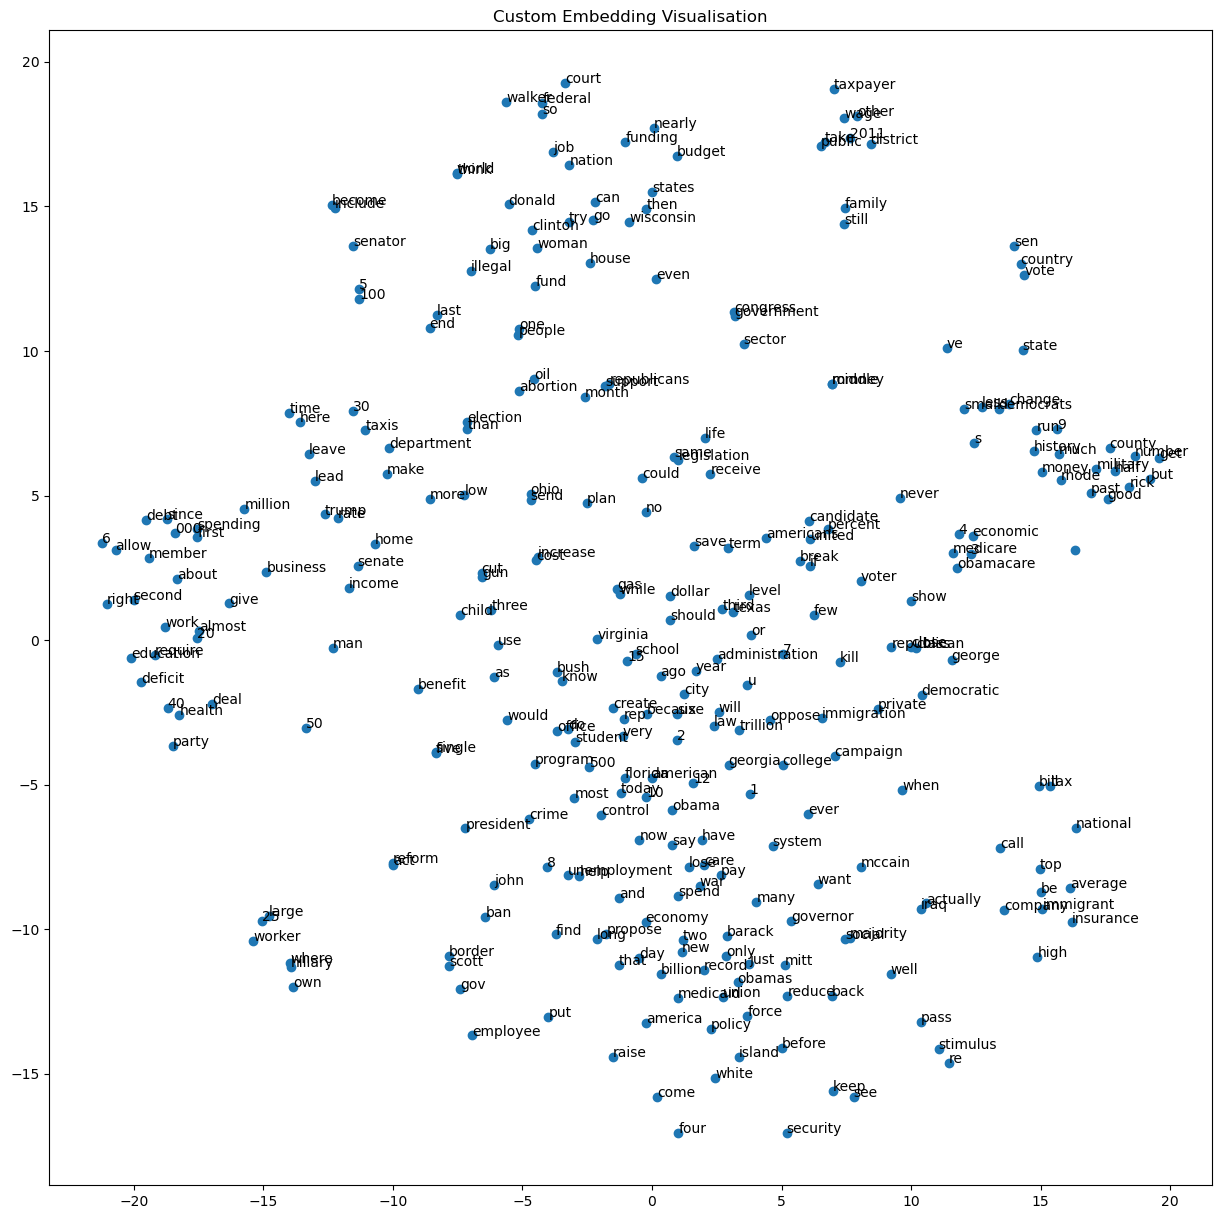

In [6]:
visualize_embeddings(embedding_matrix_custom,
                     vocabulary_dict_custom,
                     num_words=300,
                     plot_title='Custom Embedding Visualisation')


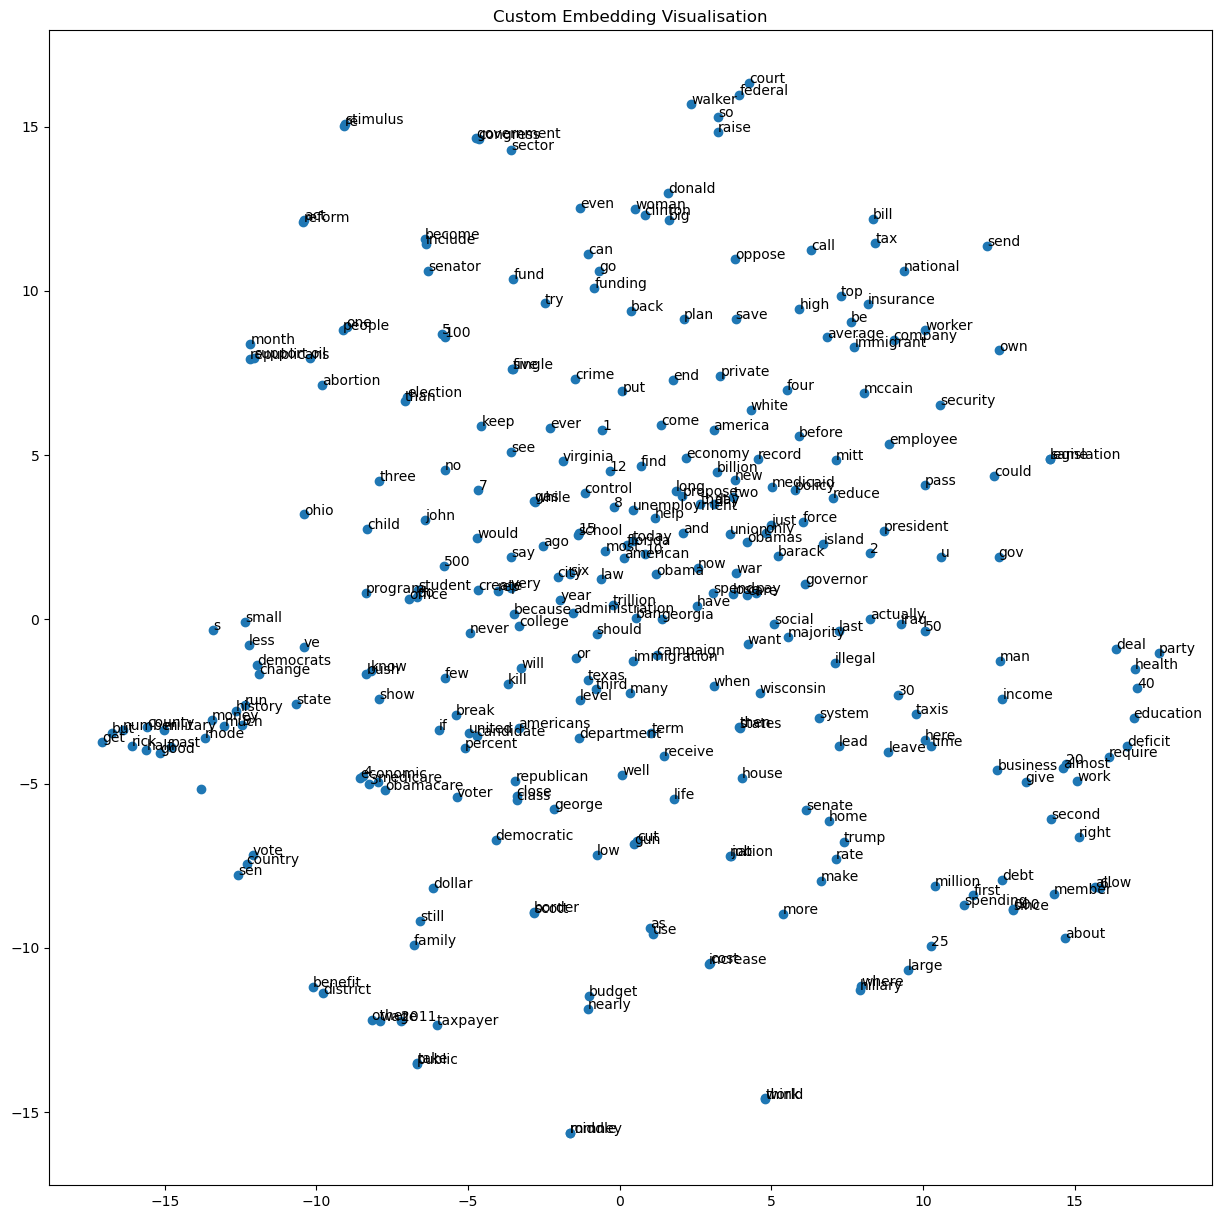

In [7]:
visualize_embeddings(embedding_matrix_custom_300d,
                     vocabulary_dict_custom,
                     num_words=300,
                     plot_title='Custom Embedding Visualisation')


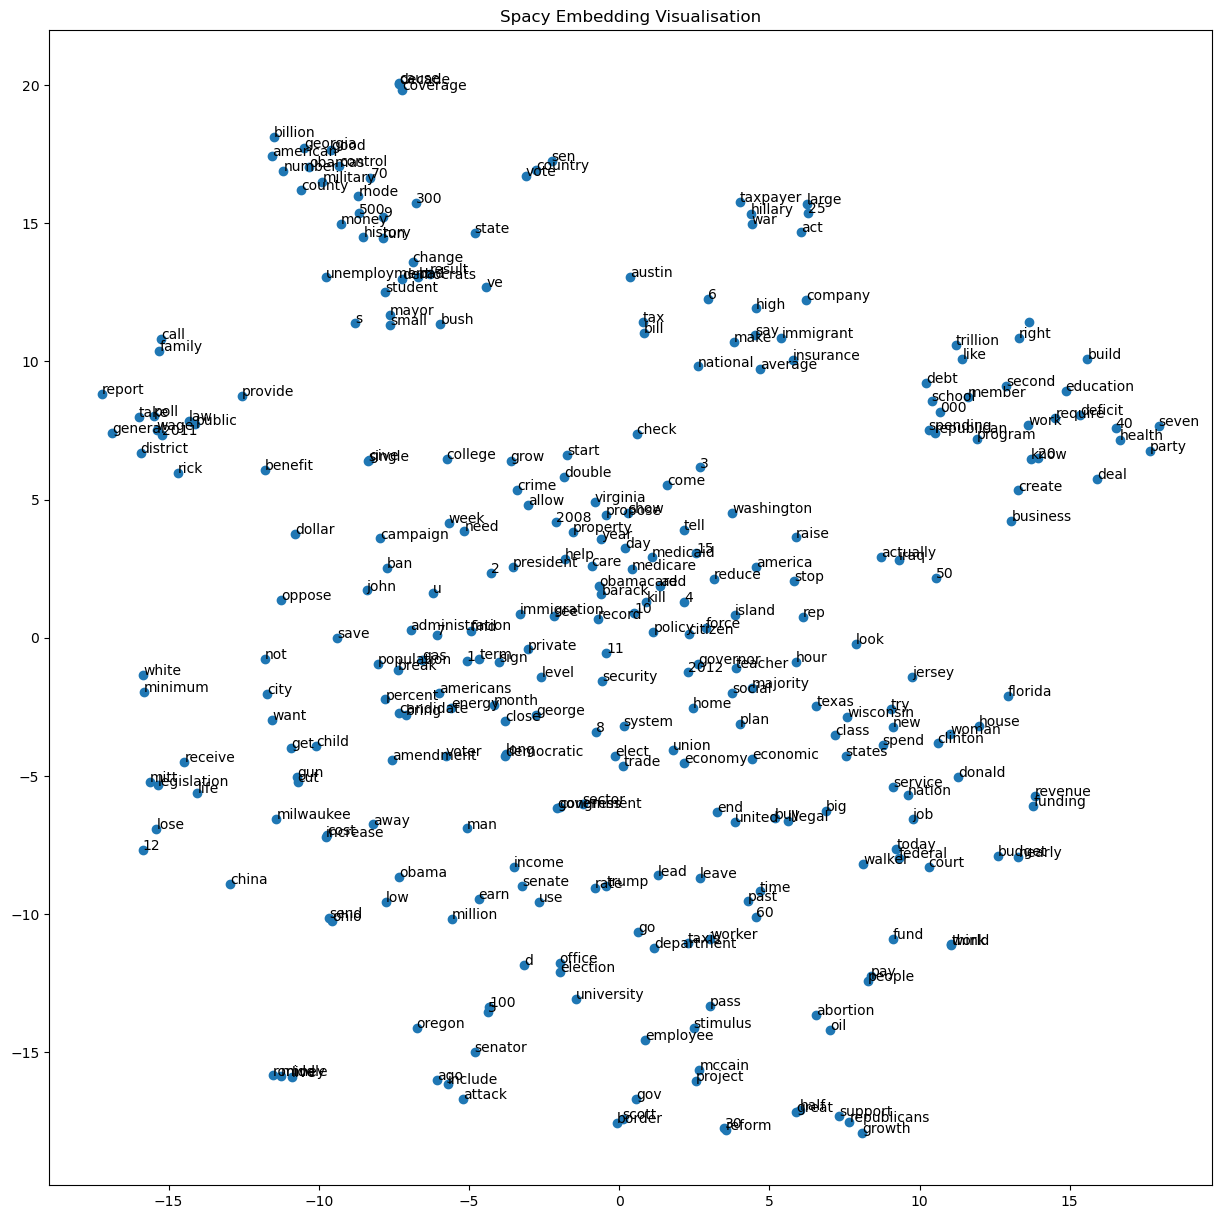

In [57]:
visualize_embeddings(embedding_matrix_spacy,
                     vocabulary_dict_spacy,
                     num_words=300,
                     plot_title='Spacy Embedding Visualisation')

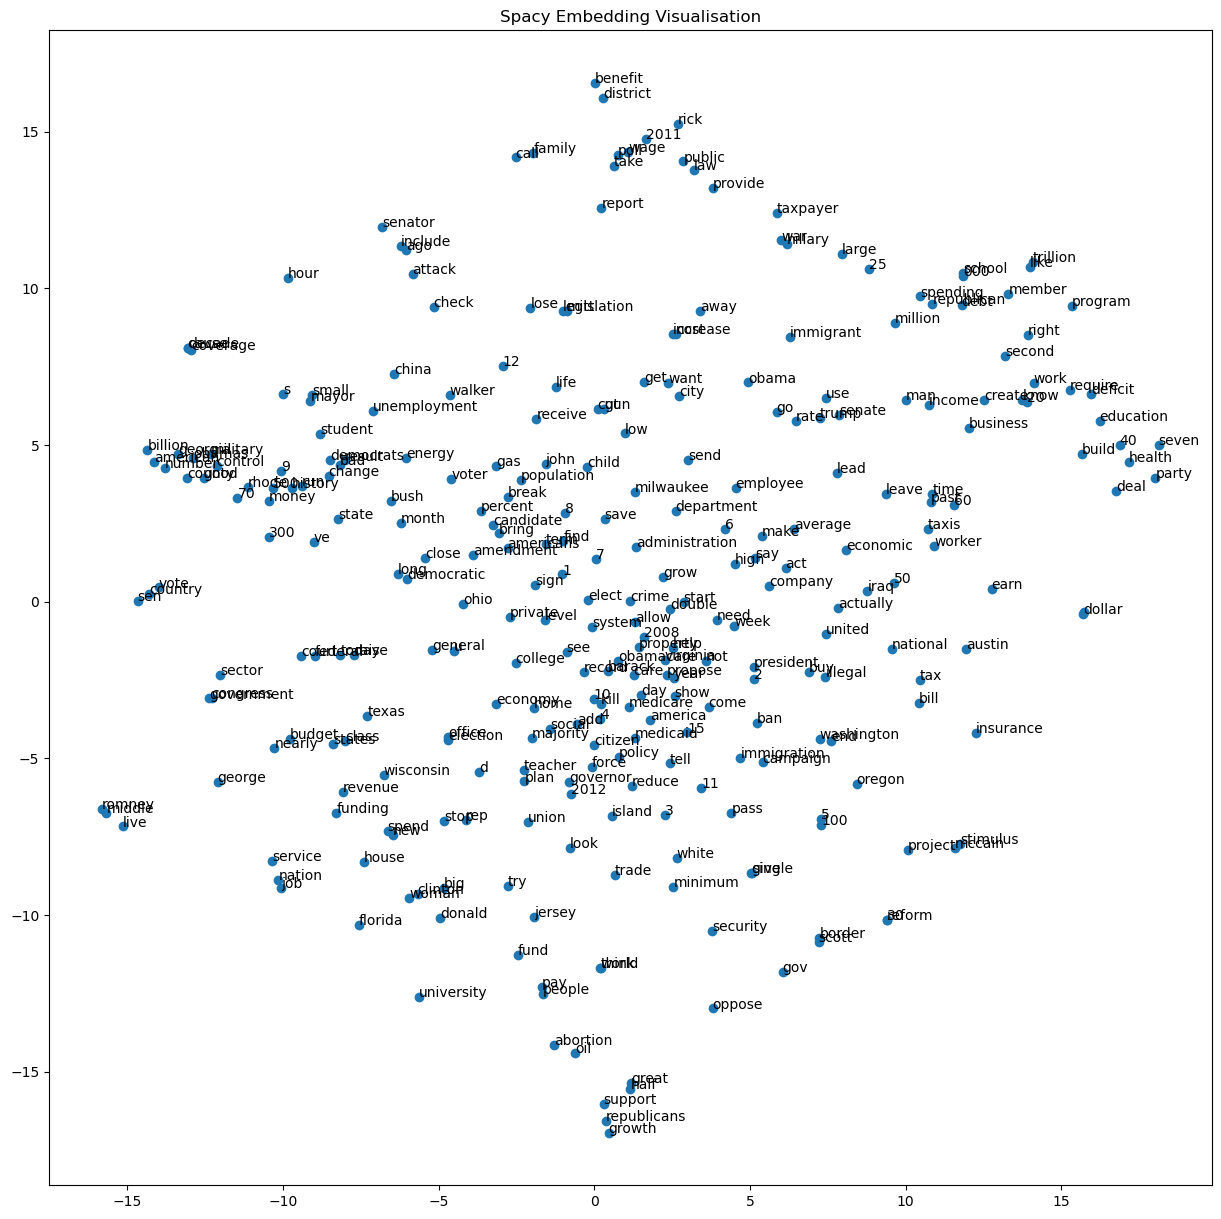

In [58]:
visualize_embeddings(embedding_matrix_spacy_300d,
                     vocabulary_dict_spacy,
                     num_words=300,
                     plot_title='Spacy Embedding Visualisation')

In [59]:
from wordcloud import WordCloud

def plot_word_cloud(vocabulary):

    ## Generate word cloud
    wordcloud = WordCloud(width=800,
                          height=400,
                          background_color='white',
                          max_words=500
                          ).generate_from_frequencies(vocabulary)

    ## Display word cloud
    plt.figure(figsize=(24,20))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

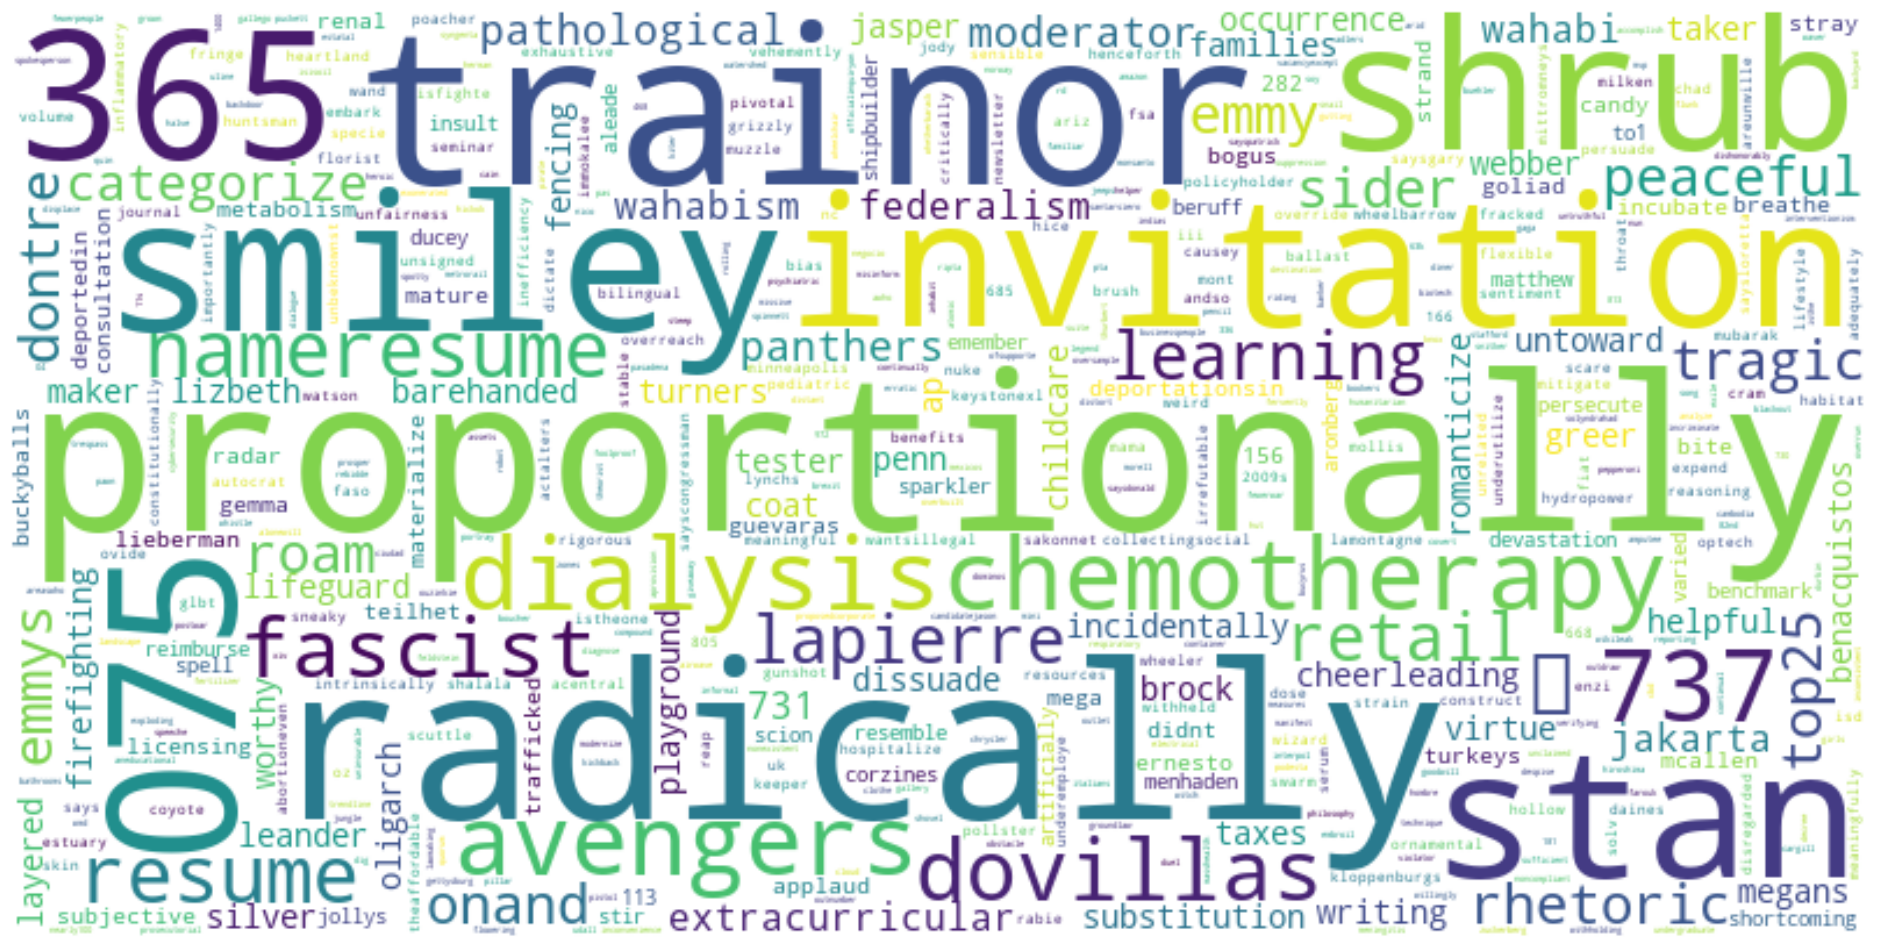

In [60]:
plot_word_cloud(vocabulary_dict_custom)

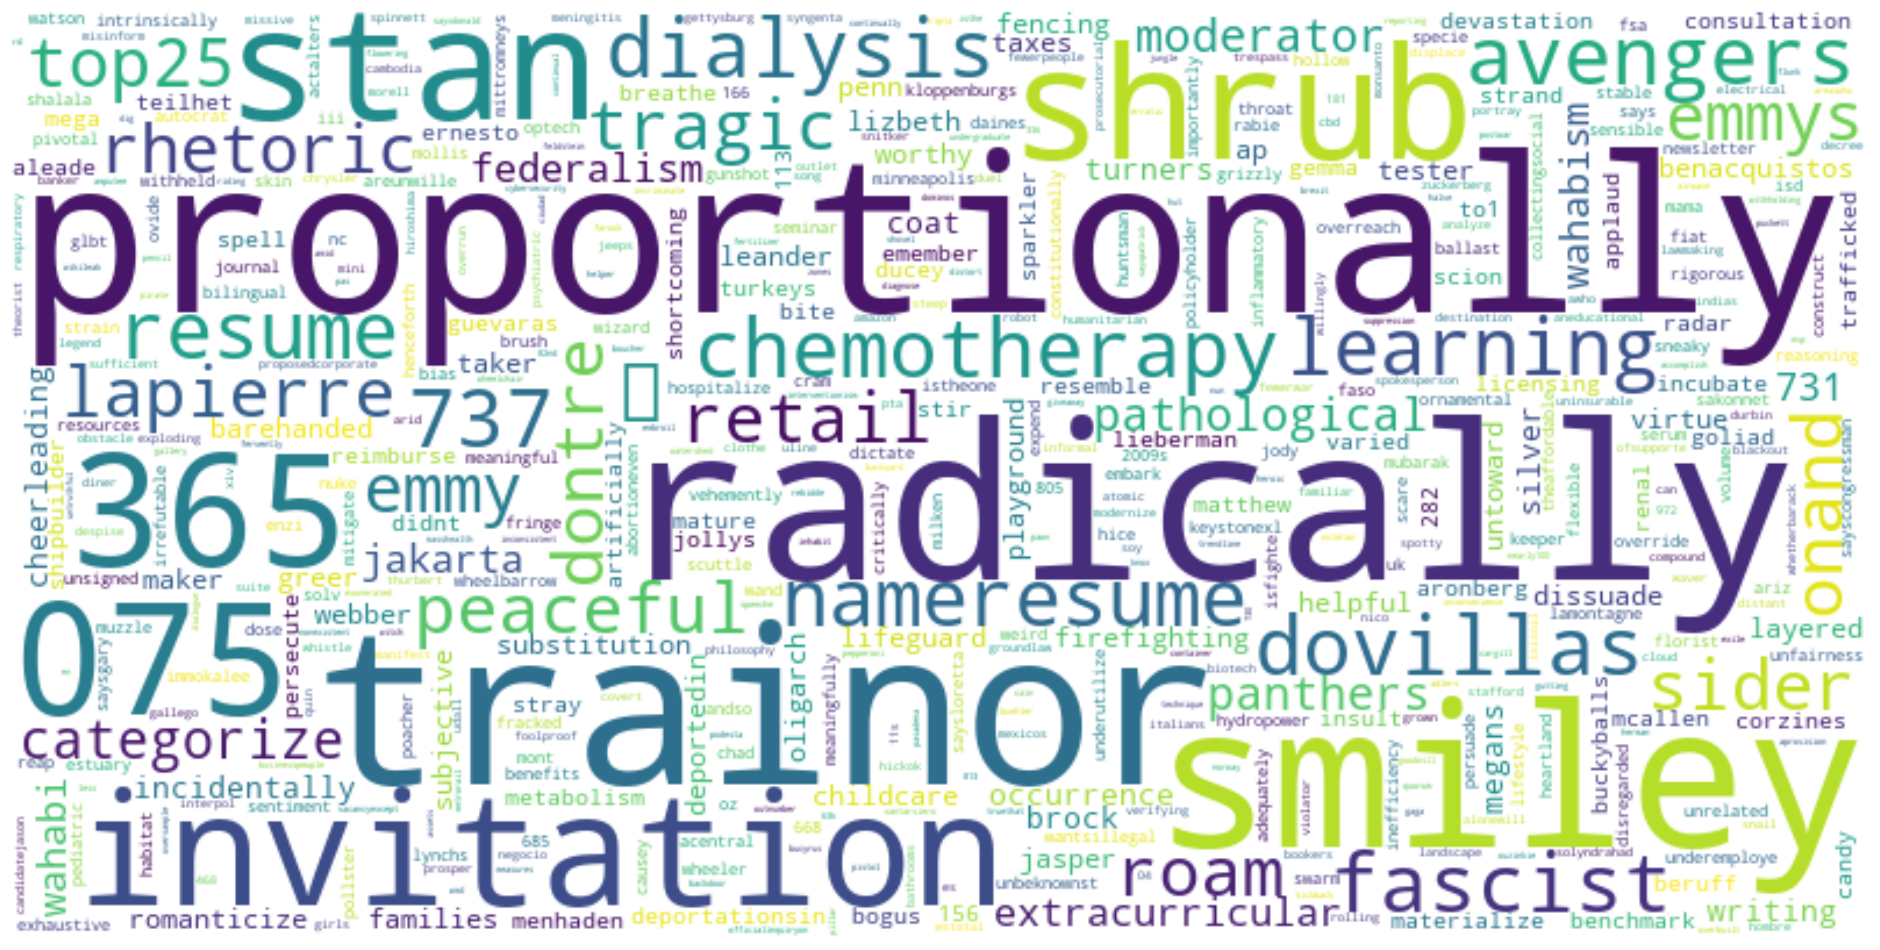

In [61]:
plot_word_cloud(vocabulary_dict_spacy)

In [102]:
# frequency of most common words in statement_custom
from collections import Counter
cnt = Counter()
for text in train_data["statement_custom"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(50)

[('be', 5642),
 ('have', 3007),
 ('say', 2883),
 ('and', 2851),
 ('year', 1234),
 ('percent', 1190),
 ('state', 1105),
 ('more', 938),
 ('do', 905),
 ('that', 793),
 ('obama', 747),
 ('tax', 706),
 ('job', 650),
 ('president', 647),
 ('million', 639),
 ('vote', 614),
 ('health', 614),
 ('people', 603),
 ('would', 572),
 ('care', 518),
 ('one', 513),
 ('will', 505),
 ('pay', 499),
 ('go', 496),
 ('new', 468),
 ('bill', 462),
 ('time', 441),
 ('or', 439),
 ('get', 436),
 ('billion', 429),
 ('country', 429),
 ('u.s.', 425),
 ('cut', 424),
 ('when', 413),
 ('texas', 393),
 ('take', 385),
 ('only', 383),
 ('law', 379),
 ('taxis', 376),
 ('high', 373),
 ('government', 373),
 ('budget', 370),
 ('rate', 369),
 ('federal', 364),
 ('make', 362),
 ('barack', 358),
 ('since', 352),
 ('if', 345),
 ('now', 337),
 ('school', 333)]

In [103]:
# frequency of most common words in statement_spacy
from collections import Counter
cnt = Counter()
for text in train_data["statement_spacy"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(50)

[('say', 2788),
 ('$', 1280),
 ('year', 1234),
 ('percent', 1190),
 ('state', 1105),
 ('obama', 747),
 ('tax', 706),
 ('job', 650),
 ('president', 647),
 ('million', 639),
 ('vote', 614),
 ('health', 614),
 ('people', 603),
 ('not', 538),
 ('care', 518),
 ('pay', 499),
 ('new', 468),
 ('bill', 462),
 ('time', 441),
 ('billion', 429),
 ('country', 429),
 ('u.s.', 425),
 ('cut', 424),
 ('texas', 393),
 ('law', 379),
 ('taxis', 376),
 ('high', 373),
 ('government', 373),
 ('budget', 370),
 ('rate', 369),
 ('federal', 365),
 ('go', 361),
 ('barack', 358),
 ('school', 333),
 ('support', 330),
 ('plan', 326),
 ('united', 311),
 ('increase', 310),
 ('states', 309),
 ('cost', 298),
 ('spend', 287),
 ('raise', 282),
 ('wisconsin', 280),
 ('take', 274),
 ('money', 263),
 ('clinton', 259),
 ('republican', 256),
 ('work', 254),
 ('s', 248),
 ('1', 246)]

## Header 1
### Header 2

#### Styles
*Italic*, **bold**, _underscore_, ~~strikethrough~~

#### Hyperlink
[hyperlink](https://www.markdownguide.org/)

#### Table
| Default | Left-aligned | Center-aligned | Right-aligned |
|---------|:-------------|:--------------:|--------------:|
| Default | Left | Center | Right |

#### Others
* Bulleted item 1
    * Bulleted subitem 1
* Bulleted item 2

***
    1. Ordered item 1
        1.1. Ordered subitem 1
    2. Ordered item 2

***
    [ ] Unchecked box
    [x] Checked box